In [1]:
#use extinction environment

import numpy as np
import scipy.signal
from math import log10, floor
from tqdm import tqdm
import shutil
from bisect import bisect_left
from random import sample

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.image as mpimg
plt.style.use('Software/stefan.mplstyle')

import pandas as pd
pd.set_option('display.max_columns', None)
# Suppress SettingWithCopyWarnings
pd.options.mode.chained_assignment = None  # default='warn'

from astropy.coordinates import SkyCoord
from astropy.coordinates import CartesianRepresentation, CartesianDifferential
import astropy.units as u

#for multiprocessing
from joblib import Parallel, delayed

#to include extinction
from __future__ import print_function
from dustmaps.edenhofer2023 import Edenhofer2023Query

#import WD models
import sys
import os
sys.path.append('Software')
import WD_models


MsunCGS=1.989*10**33 #g
RsunCGS=6.955*10**10 #cm
cCGS=2.99792458*10**10 #cm/s
GCGS=6.6743*10**(-8) #cm^3 g^-1 s^-2



# This notebook simulates how various noise sources impact our ability to detect the signal of ULDM
We simulate the effect of ULDM on WDs on simple square ULDM grid and we add in the effects of measurement noise (both in physical parameters and in distance to WD), binary contamination, and thin H envelope contamination.

- Draw a truth sample of WDs and initialize the measured values 
- Add in the effect of the ULDM field on the radius based on the initial parameters and update the measured parameters
- Add in thin H envelope WDs and update the measured parameters of the star to the thin H layer value
- Add in distance uncertainty
    - The true location of the WD determines the effect of the ULDM field on the star. But we might measure the star to be in a slightly different location, impacting the distance between 2 WDs in calculating Moran's I
- Add in measured parameter uncertainty
    - In practice, we don't know the true radius of the star and instead we combine the measured logg and radius to get the location of the star relative to the mass-radius relation and use the difference between the measured and theoretical radius as the input when calculating Moran's I.
- Add in binary contamination


# Check if various parameters have distance dependence

In [2]:
#import the VAC catalog measurements with quality cuts
wd_table=pd.read_csv('csv/wd_table.csv')


/var/folders/ny/bjybyvhj6s9_2ms5cmld1xbc0000gn/T/ipykernel_91205/646736903.py:2: DtypeWarning: Columns (18,25,77,88,100,109,114,126,127,292) have mixed types. Specify dtype option on import or set low_memory=False.
  wd_table=pd.read_csv('csv/wd_table.csv')


In [3]:
dist_bins=np.arange(0,1050,50)
print(dist_bins)

#get the range and center for each bin
dist_bin_ranges=[]
dist_bin_centers=[]
for i in range(len(dist_bins)-1):
    array=[dist_bins[i],dist_bins[i+1]]
    half=0.5*(dist_bins[i]+dist_bins[i+1])
    dist_bin_ranges.append(array)
    dist_bin_centers.append(half)
dist_bin_nums=np.arange(0,len(dist_bin_ranges))

#save the bin info
np.savez('csv/dist_bins',bins=dist_bins,ranges=dist_bin_ranges,centers=dist_bin_centers,nums=dist_bin_nums)

[   0   50  100  150  200  250  300  350  400  450  500  550  600  650
  700  750  800  850  900  950 1000]


In [4]:
def bin_by_dist(table,verbose=False):
    #bin by distance
    dist_bin_ids=[]
    dist_bin_id_ranges=[]
    dist_bin_id_centers=[]
    for i in range(len(table)):
        dist_val=table['r_med_geo'][i]
        for j in range(len(dist_bin_ranges)):
            if dist_bin_ranges[j][0]<=dist_val<dist_bin_ranges[j][1]:
                dist_bin_ids.append(j)
                dist_bin_id_ranges.append(dist_bin_ranges[j])
                dist_bin_id_centers.append(dist_bin_centers[j])
    table['dist_bin_id']=dist_bin_ids
    table['dist_bin_range']=dist_bin_id_ranges
    table['dist_bin_center']=dist_bin_id_centers
    
    if verbose==True:
        for i in range(len(dist_bin_ranges)):
            bin_num=dist_bin_nums[i]
            bin_range=dist_bin_ranges[i]
            tmp=table.query('dist_bin_id==@bin_num')
            print('Bin id=', bin_num,' Bin range=',bin_range,' pc, Number of WDs in bin=',len(tmp))
            
    return(table)

In [5]:
binning_table=bin_by_dist(wd_table,verbose=True)

Bin id= 0  Bin range= [0, 50]  pc, Number of WDs in bin= 124
Bin id= 1  Bin range= [50, 100]  pc, Number of WDs in bin= 774
Bin id= 2  Bin range= [100, 150]  pc, Number of WDs in bin= 1501
Bin id= 3  Bin range= [150, 200]  pc, Number of WDs in bin= 1550
Bin id= 4  Bin range= [200, 250]  pc, Number of WDs in bin= 1339
Bin id= 5  Bin range= [250, 300]  pc, Number of WDs in bin= 1137
Bin id= 6  Bin range= [300, 350]  pc, Number of WDs in bin= 997
Bin id= 7  Bin range= [350, 400]  pc, Number of WDs in bin= 846
Bin id= 8  Bin range= [400, 450]  pc, Number of WDs in bin= 621
Bin id= 9  Bin range= [450, 500]  pc, Number of WDs in bin= 436
Bin id= 10  Bin range= [500, 550]  pc, Number of WDs in bin= 343
Bin id= 11  Bin range= [550, 600]  pc, Number of WDs in bin= 197
Bin id= 12  Bin range= [600, 650]  pc, Number of WDs in bin= 145
Bin id= 13  Bin range= [650, 700]  pc, Number of WDs in bin= 63
Bin id= 14  Bin range= [700, 750]  pc, Number of WDs in bin= 52
Bin id= 15  Bin range= [750, 800]  pc

In [6]:
def binned_med_std(table,parameter):
                    
    #calculate the mean/std x for each bin
    bin_nums=dist_bin_nums
    bin_ranges=dist_bin_ranges
    bin_centers=dist_bin_centers
    bin_id_key='dist_bin_id'

    med_xs=[]
    std_xs=[]
    num_obs_per_bin=[]
    for i in range(len(bin_nums)):
        tmp=table.query(bin_id_key+'=='+str(bin_nums[i]))
        if parameter=='e_dist':
            x=tmp['r_hi_geo']-tmp['r_lo_geo']
        else:
            x=tmp[parameter]
        if len(x)>0:
            #calculate mean and std of x
            med_x=np.nanmedian(x)#nanmean(x)
            std_x=np.nanstd(x)
        else: #if bin is empty fill with nan values
            med_x=np.nan
            std_x=np.nan
        #record results
        med_xs.append(med_x)
        std_xs.append(std_x)
        #record how many observations used in averaging
        num_obs=len(tmp)
        num_obs_per_bin.append(num_obs)

    #convert bin ranges to string
    bin_ranges_str=[]
    for i in range(len(bin_ranges)):
        bin_ranges_str.append(str(bin_ranges[i]))
    
    #save parameters
    final_avg_table=pd.DataFrame()
    final_avg_table['bin_id']=bin_nums
    final_avg_table['bin_range']=bin_ranges_str
    final_avg_table['bin_center']=bin_centers
    
    final_avg_table['med']=med_xs
    final_avg_table['std']=std_xs
    final_avg_table['num_obs_per_bin']=num_obs_per_bin
    
    #re-order by bin_id
    final_avg_table=final_avg_table.sort_values(by=['bin_id'])
    
    return(final_avg_table)

In [7]:
#get the median and std for each bin
mass_dist=binned_med_std(binning_table,'mass_rad_theory')
teff_dist=binned_med_std(binning_table,'teff_phot')
l_dist=binned_med_std(binning_table,'l')
b_dist=binned_med_std(binning_table,'b')
e_dist_dist=binned_med_std(binning_table,'e_dist')
e_radius_dist=binned_med_std(binning_table,'e_radius_phot_full')
e_teff_dist=binned_med_std(binning_table,'e_teff_phot_full')
e_logg_dist=binned_med_std(binning_table,'e_logg_prf_coadd_full')


In [8]:
#re-format the bin range columns into min and max
#these are the tables we will use
tables=[e_dist_dist,e_radius_dist,e_teff_dist,e_logg_dist]
for table in tables:
    bin_mins=[]
    bin_maxes=[]
    for i in range(len(table)):
        min_val,max_val=table['bin_range'][i].strip('[]').replace(",", "").split()
        bin_mins.append(float(min_val))
        bin_maxes.append(float(max_val))
    table['bin_min']=bin_mins
    table['bin_max']=bin_maxes

In [9]:
#save these tables

binning_table.to_csv('csv/binning_table.csv',index=False)

mass_dist.to_csv('csv/mass_dist.csv',index=False)
teff_dist.to_csv('csv/teff_dist.csv',index=False)
l_dist.to_csv('csv/l_dist.csv',index=False)
b_dist.to_csv('csv/b_dist.csv',index=False)
e_dist_dist.to_csv('csv/e_dist_dist.csv',index=False)
e_radius_dist.to_csv('csv/e_radius_dist.csv',index=False)
e_teff_dist.to_csv('csv/e_teff_dist.csv',index=False)
e_logg_dist.to_csv('csv/e_logg_dist.csv',index=False)


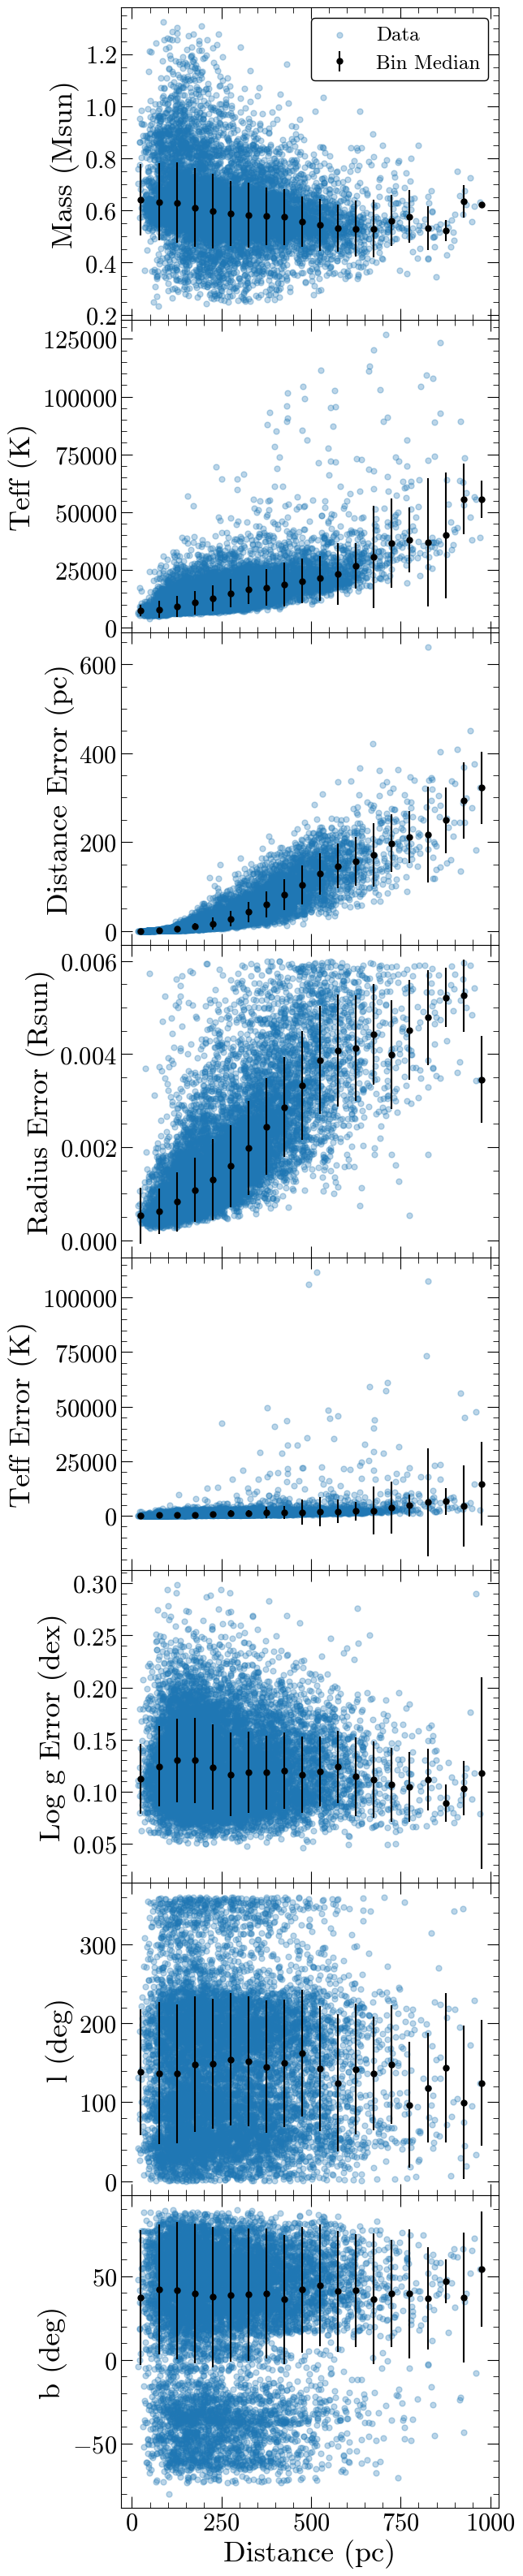

In [10]:
#plot these parameters as a function of distance
fig, ((ax1),(ax2),(ax3),(ax4),(ax5),(ax6),(ax7),(ax8)) =plt.subplots(8,1,figsize=(6,40),sharex=True)
ax1.scatter(binning_table['r_med_geo'],binning_table['mass_rad_theory'],rasterized=True,alpha=0.3,label='Data')
ax1.errorbar(mass_dist['bin_center'],mass_dist['med'], yerr=mass_dist['std'],
             fmt='o', color='black', ecolor = 'black',label='Bin Median')
ax1.set_ylabel('Mass (Msun)')
ax1.legend()

ax2.scatter(binning_table['r_med_geo'],binning_table['teff_phot'],rasterized=True,alpha=0.3,label='Data')
ax2.errorbar(teff_dist['bin_center'],teff_dist['med'], yerr=teff_dist['std'],
             fmt='o', color='black', ecolor = 'black',label='Bin Median')
ax2.set_ylabel('Teff (K)')

ax3.scatter(binning_table['r_med_geo'],binning_table['r_hi_geo']-binning_table['r_lo_geo'],rasterized=True,alpha=0.3,label='Data')
ax3.errorbar(e_dist_dist['bin_center'],e_dist_dist['med'], yerr=e_dist_dist['std'],
             fmt='o', color='black', ecolor = 'black',label='Bin Median')
ax3.set_ylabel('Distance Error (pc)')

ax4.scatter(binning_table['r_med_geo'],binning_table['e_radius_phot_full'],rasterized=True,alpha=0.3,label='Data')
ax4.errorbar(e_radius_dist['bin_center'],e_radius_dist['med'], yerr=e_radius_dist['std'],
             fmt='o', color='black', ecolor = 'black',label='Bin Median')
ax4.set_ylabel('Radius Error (Rsun)')

ax5.scatter(binning_table['r_med_geo'],binning_table['e_teff_phot_full'],rasterized=True,alpha=0.3,label='Data')
ax5.errorbar(e_teff_dist['bin_center'],e_teff_dist['med'], yerr=e_teff_dist['std'],
             fmt='o', color='black', ecolor = 'black',label='Bin Median')
ax5.set_ylabel('Teff Error (K)')

ax6.scatter(binning_table['r_med_geo'],binning_table['e_logg_prf_coadd_full'],rasterized=True,alpha=0.3,label='Data')
ax6.errorbar(e_logg_dist['bin_center'],e_logg_dist['med'], yerr=e_logg_dist['std'],
             fmt='o', color='black', ecolor = 'black',label='Bin Median')
ax6.set_ylabel('Log g Error (dex)')

ax7.scatter(binning_table['r_med_geo'],binning_table['l'],rasterized=True,alpha=0.3,label='Data')
ax7.errorbar(l_dist['bin_center'],l_dist['med'], yerr=l_dist['std'],
             fmt='o', color='black', ecolor = 'black',label='Bin Median')
ax7.set_ylabel('l (deg)')

ax8.scatter(binning_table['r_med_geo'],binning_table['b'],rasterized=True,alpha=0.3,label='Data')
ax8.errorbar(b_dist['bin_center'],b_dist['med'], yerr=b_dist['std'],
             fmt='o', color='black', ecolor = 'black',label='Bin Median')
ax8.set_ylabel('b (deg)')
ax8.set_xlabel('Distance (pc)')

plt.subplots_adjust(hspace=0)

#plt.savefig('meas_err_as_function_dist.pdf', dpi=300)


# Define functions 

In [11]:
# Import the La Plata WD Models http://evolgroup.fcaglp.unlp.edu.ar/TRACKS/newtables.html
la_plata_mass=pd.read_csv('Software/whitedwarfsZ0.02/DAmassradiusZ0.02_readable.txt',delimiter=' ')
la_plata_mass=la_plata_mass.rename(columns={"Unnamed: 1": "logteff"})
la_plata_mass=la_plata_mass.drop(['log(teff)/log(g)'],axis=1)
#reset the indices
indices=np.arange(0,len(la_plata_mass))
la_plata_mass.set_index(indices,inplace=True)

la_plata_radius=pd.read_csv('Software/whitedwarfsZ0.02/DAmassradiusZ0.02_readable.txt',delimiter=' ')
la_plata_radius=la_plata_radius.rename(columns={"Unnamed: 1": "logteff"})
la_plata_radius=la_plata_radius.drop(['log(teff)/log(g)'],axis=1)
#reset the indices
indices=np.arange(0,len(la_plata_radius))
la_plata_radius.set_index(indices,inplace=True)

#separate mass and radius info
for col in la_plata_mass.columns.to_list()[1:]:
    masses=[]
    radii=[]
    for i in range(len(la_plata_mass)):
        mass,radius=la_plata_mass[col][i].split(',')
        masses.append(float(mass))
        radii.append(float(radius))
    la_plata_mass[col]=masses
    la_plata_radius[col]=radii

#turn models into interpolation grids

#make grid of mass/radius as function of teff/logg
rows=la_plata_mass['logteff']
teffs = 10**(rows)
columns=la_plata_radius.columns.to_list()[1:]
loggs=[float(i) for i in columns]
mass_teff_logg_grid = np.zeros((len(teffs), len(loggs), 1))
radius_teff_logg_grid = np.zeros((len(teffs), len(loggs), 1))
for i in range(len(teffs)):
    for j in range(len(loggs)):
        logteff=rows[i]
        mass_teff_logg_grid[i,j] = la_plata_mass.query('logteff==@logteff')[columns[j]]
        radius_teff_logg_grid[i,j] = la_plata_radius.query('logteff==@logteff')[columns[j]]
    
#get equal-sized arrays
teffs_long=[]
loggs_long=[]
masses_long=[]
radii_long=[]
for i in range(len(teffs)):
    for j in range(len(loggs)):
        logteff=rows[i]
        teff=teffs[i]
        logg=loggs[j]
        mass= la_plata_mass.query('logteff==@logteff')[columns[j]].to_list()[0]
        radius= la_plata_radius.query('logteff==@logteff')[columns[j]].to_list()[0]
        teffs_long.append(teff)
        loggs_long.append(logg)
        masses_long.append(mass)
        radii_long.append(radius)   
teffs_long=np.asarray(teffs_long)
loggs_long=np.asarray(loggs_long)
masses_long=np.asarray(masses_long)
radii_long=np.asarray(radii_long)

#define the interpolation functions
mass_from_logg_teff=WD_models.interp_xy_z_func(x=loggs_long, y=teffs_long, z=masses_long, interp_type='linear')     
mass_from_radius_teff=WD_models.interp_xy_z_func(x=radii_long, y=teffs_long, z=masses_long, interp_type='linear')  
radius_from_logg_teff=WD_models.interp_xy_z_func(x=loggs_long, y=teffs_long, z=radii_long, interp_type='linear')  
radius_from_mass_teff=WD_models.interp_xy_z_func(x=masses_long, y=teffs_long, z=radii_long, interp_type='linear')  
mass_from_radius_teff=WD_models.interp_xy_z_func(x=radii_long, y=teffs_long, z=masses_long, interp_type='linear')  
logg_from_mass_teff=WD_models.interp_xy_z_func(x=masses_long, y=teffs_long, z=loggs_long, interp_type='linear')     


## Make simulated field and WDs

In [12]:
def get_initial_truth_sample(table, sample_size, grid_size, plot=False):
    #this function draws a mass sample from our VAC radius+theory distribution
    #and a teff sample from our measured photometric temperatures
    #using the La Plata models, the radii and loggs of these samples are computed
    
    #place the WDs on a 3D grid centered at the earth of size=grid_size
    #by drawing distances, l, and b from our VAC distrbutions
    #then convert distance, l, and b to cartesian coordinates
    
    draw_size=int(1.5*sample_size)

    #draw d,l,b coordinates
    all_measured_distances=table.query('r_med_geo<@grid_size')[['r_med_geo','dist_bin_id']]
    distance_sample_full = all_measured_distances.sample(n = draw_size,replace = True)
    distance_sample=np.array(distance_sample_full['r_med_geo'].to_list())
    distance_bin_sample=np.array(distance_sample_full['dist_bin_id'].to_list())
    #see table above, l and b distributions are not distance-dependent
    all_measured_ls=table['l'] 
    l_sample = np.random.choice(all_measured_ls, size = draw_size, replace = True)
    all_measured_bs=table['b']
    b_sample = np.random.choice(all_measured_bs, size = draw_size, replace = True)

    #convert l, b, and distance (which are in galactic coordinates) to a cartesian representation
    coords_cartesian=SkyCoord(l=l_sample*u.deg, 
                              b=b_sample*u.deg, 
                              distance=distance_sample*u.pc,
                              frame='galactic')
    coords_cartesian.representation_type = 'cartesian'
    u_sample=coords_cartesian.u.value
    v_sample=coords_cartesian.v.value
    w_sample=coords_cartesian.w.value

    simulated_wds=pd.DataFrame()
    simulated_wds['dist_bin_id']=distance_bin_sample
    simulated_wds['distance_init']=distance_sample
    simulated_wds['l_init']=l_sample
    simulated_wds['b_init']=b_sample
    simulated_wds['u_init']=u_sample
    simulated_wds['v_init']=v_sample
    simulated_wds['w_init']=w_sample

    #sort by distance bin
    simulated_wds=simulated_wds.sort_values(by='dist_bin_id', ascending=True)
    #reset the indices
    indices=np.arange(0,len(simulated_wds))
    simulated_wds.set_index(indices,inplace=True)

    #get each bin id and number of simulated WDs in that bin
    id_counts=simulated_wds['dist_bin_id'].value_counts().sort_index()
    bin_ids=id_counts.index.to_list()
    bin_counts=id_counts.values

    #for each bin id, sample the masses and temperatures from that distance bin
    mass_sample=[]
    teff_sample=[]
    for i in range(len(bin_ids)):
        distance_bin=bin_ids[i]
        bin_count=bin_counts[i]
        tmp=binning_table.query('dist_bin_id==@distance_bin & mass_rad_theory>0.2 & mass_rad_theory<1.2')
        sample_rows=tmp.sample(n=bin_count,replace=True)
        mass_sample.extend(sample_rows['mass_rad_theory'].to_list())
        teff_sample.extend(sample_rows['teff_phot'].to_list())
    mass_sample=np.array(mass_sample)
    teff_sample=np.array(teff_sample)

    #for given mass and teff samples, get the radii sample
    radius_sample = radius_from_mass_teff(mass_sample, teff_sample)
    #for given mass and teff samples, get the logg sample
    logg_sample = logg_from_mass_teff(mass_sample, teff_sample)

    #add to the dataframe
    simulated_wds['mass_init']=mass_sample
    simulated_wds['teff_init']=teff_sample
    simulated_wds['radius_init']=radius_sample
    simulated_wds['logg_init']=logg_sample

    # drop nan samples or WDs with radii>0.029 or logg<7 (these are ELMs)
    simulated_wds=simulated_wds.dropna()
    simulated_wds=simulated_wds.query('radius_init<0.029 & logg_init>7')

    #for now, truth parameters=measured parameters
    #so record these values until the measured/truth parameters are updated by other effects
    simulated_wds['teff_measured']=simulated_wds['teff_init']
    simulated_wds['radius_measured']=simulated_wds['radius_init']
    simulated_wds['logg_measured']=simulated_wds['logg_init']
    simulated_wds['distance_measured']=simulated_wds['distance_init']
    simulated_wds['l_measured']=simulated_wds['l_init']
    simulated_wds['b_measured']=simulated_wds['b_init']
    simulated_wds['u_measured']=simulated_wds['u_init']
    simulated_wds['v_measured']=simulated_wds['v_init']
    simulated_wds['w_measured']=simulated_wds['w_init']

    #reduce down to the desired sample size
    simulated_wds= simulated_wds.sample(n=sample_size,replace=False)
    #reset the indices
    indices=np.arange(0,len(simulated_wds))
    simulated_wds.set_index(indices,inplace=True)

    if plot==True:
        #plot the samples
        fig, ((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9),(ax10,ax11,ax12)) = plt.subplots(4, 3,figsize=(15,23))
        ax1.hist(simulated_wds['mass_init'], density=True, bins='auto', histtype='stepfilled')
        ax1.axvline(x = 0.6, color = 'r')
        ax1.set_xlim([0,1.3])
        ax1.set_xlabel('Mass Sample (Msun)')

        ax2.hist(simulated_wds['teff_init'], density=True, bins='auto', histtype='stepfilled')
        ax2.set_xlabel('Teff Sample (K)')

        ax3.hist(simulated_wds['radius_init'], density=True, bins='auto', histtype='stepfilled')
        ax3.set_xlabel('Radius Sample\n(Rsun)')

        ax4.hist(simulated_wds['logg_init'], density=True, bins='auto', histtype='stepfilled')
        ax4.set_xlabel('Logg Sample\n(dex)')

        ax5.set_axis_off()
        ax6.set_axis_off()

        ax7.hist(simulated_wds['distance_init'], density=True, bins='auto', histtype='stepfilled')
        ax7.set_xlabel('Distance Sample\n(pc)')

        ax8.hist(simulated_wds['l_init'], density=True, bins='auto', histtype='stepfilled')
        ax8.set_xlabel('l Sample\n(deg)')

        ax9.hist(simulated_wds['b_init'], density=True, bins='auto', histtype='stepfilled')
        ax9.set_xlabel('b Sample\n(deg)')

        ax10.hist(simulated_wds['u_init'], density=True, bins='auto', histtype='stepfilled')
        ax10.set_xlabel('U Sample\n(pc)')

        ax11.hist(simulated_wds['v_init'], density=True, bins='auto', histtype='stepfilled')
        ax11.set_xlabel('V Sample\n(pc)')

        ax12.hist(simulated_wds['w_init'], density=True, bins='auto', histtype='stepfilled')
        ax12.set_xlabel('W Sample\n(pc)')

        plt.subplots_adjust(wspace = 0.3,hspace=0.4)

        plt.show()
        
    return(simulated_wds)

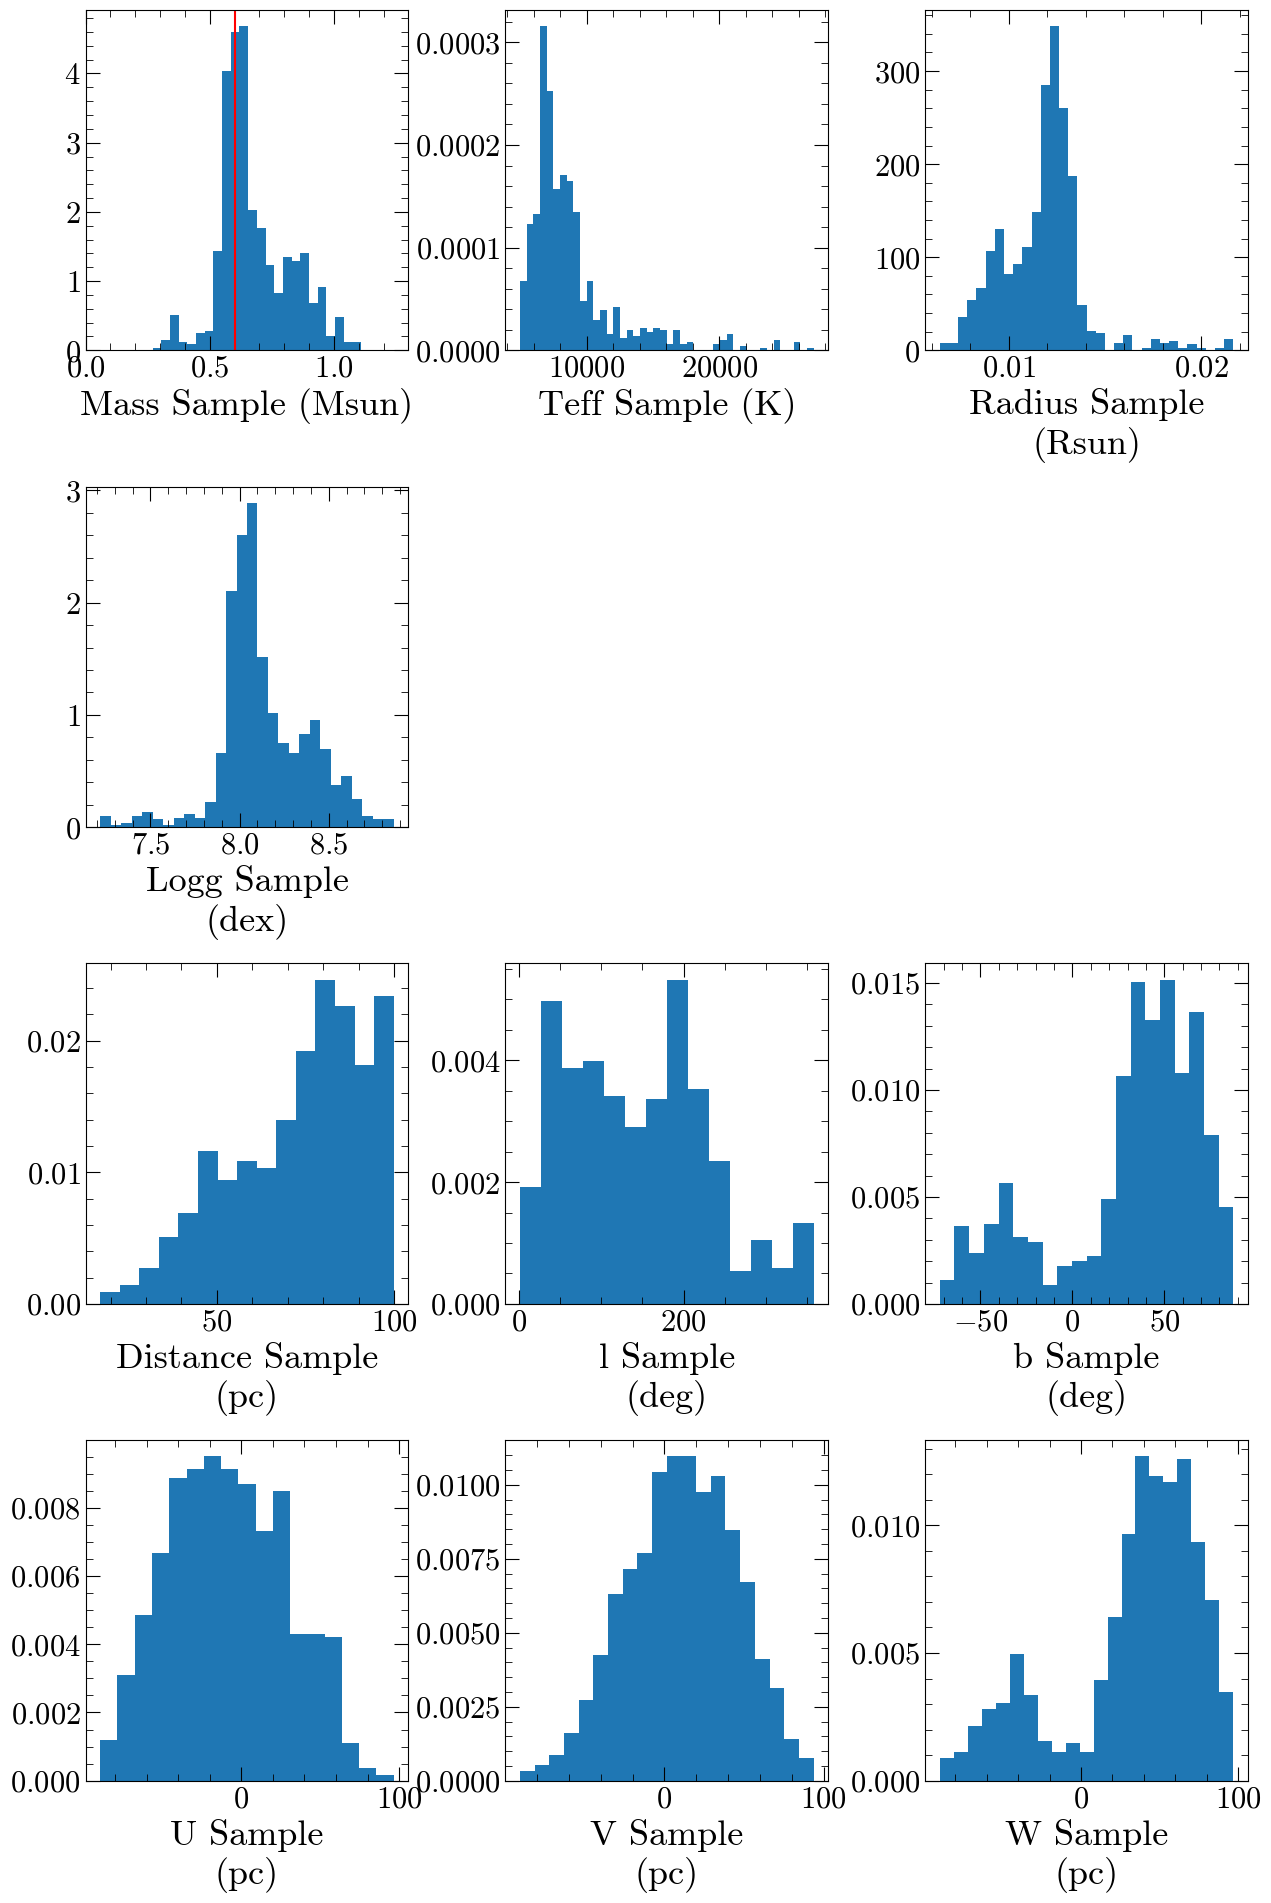

In [13]:
sample_size=1000
grid_size=100

simulated_wds=get_initial_truth_sample(binning_table, sample_size, grid_size,plot=True)

In [14]:
def background_field(U,V,W,corr_length):
    return(np.sin(np.pi*U/corr_length)*np.sin(np.pi*V/corr_length)*np.sin(np.pi*W/corr_length)+1)

def mass_variation_field(U,V,W,corr_length,epsilon):
    return(epsilon*np.sin(np.pi*U/corr_length)*np.sin(np.pi*V/corr_length)*np.sin(np.pi*W/corr_length))

def get_mass_variation_sample(corr_length,epsilon,simulated_wds,plot=False):
    
    #this function gives the new measured radius given the background ULDM field
    
    radius_sample=simulated_wds['radius_init']
    logg_sample=simulated_wds['logg_init']
    u_sample=simulated_wds['u_init']
    v_sample=simulated_wds['v_init']
    w_sample=simulated_wds['w_init']
    
    #get the electron mass variation of each WD
    dme_sample=mass_variation_field(u_sample,v_sample,w_sample,corr_length,epsilon)
    
    #modify the radius
    radius_dme_sample=[]
    for i in range(len(radius_sample)):
        radius=radius_sample[i]
        dme=dme_sample[i]
        new_radius=(1+dme)*radius
        radius_dme_sample.append(new_radius)
    
    #update the measured parameters with the effect of the ULDM field
    simulated_wds['dme']=dme_sample
    simulated_wds['radius_measured']=radius_dme_sample
    
    #at fixed mass, the variation in the radius will also cause the logg to change      
    logg_dme_sample=np.log10(GCGS*simulated_wds['mass_init']*MsunCGS/(simulated_wds['radius_measured']*RsunCGS)**2)
    simulated_wds['logg_measured']=logg_dme_sample
    
    #fixed mass so do not change mass from mass init
    
    if plot==True:
        #plot the difference in parameters
        fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,5))
        ax1.hist(np.array(radius_sample)-np.array(radius_dme_sample), bins='auto', histtype='stepfilled')
        ax1.set_xlabel('(No ULDM-ULDM) Radius (Rsun)')
        ax2.hist(np.array(logg_sample)-np.array(logg_dme_sample), bins='auto', histtype='stepfilled')
        ax2.set_xlabel('(No ULDM-ULDM) Logg (dex)')
        plt.show()
        
    return(simulated_wds)

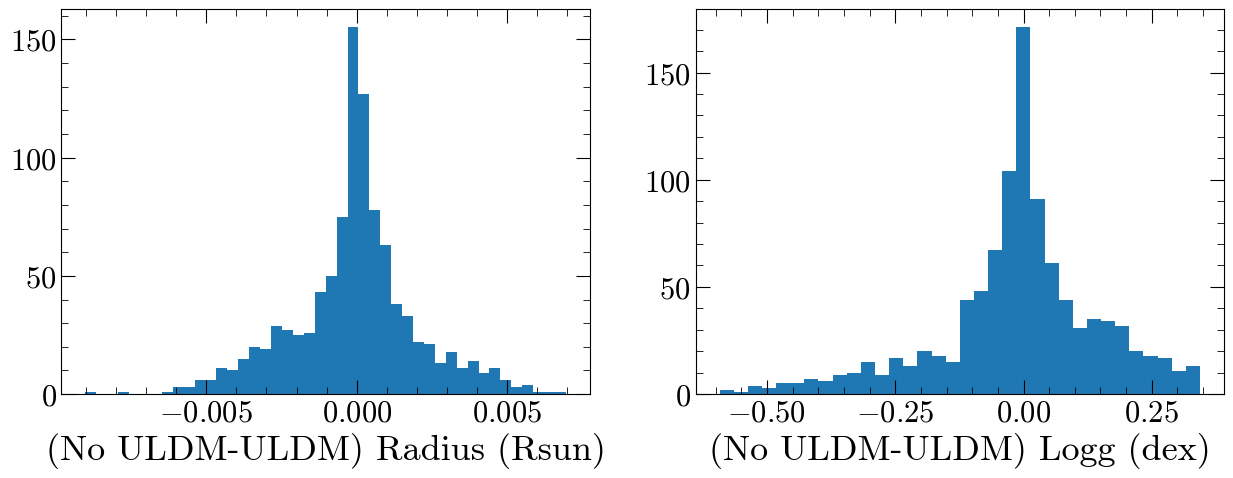

In [15]:
corr_length=20 #pc
epsilon=0.5 #max me variation

simulated_wds=get_initial_truth_sample(binning_table, sample_size, grid_size)
simulated_wds=get_mass_variation_sample(corr_length,epsilon,simulated_wds,plot=True)


In [16]:
def background_field2D(X,Y,corr_length):
    return(np.sin(np.pi*X/corr_length)*np.sin(np.pi*Y/corr_length)+1)

def mass_variation_field2D(X,Y,corr_length,epsilon):
    return(epsilon*np.sin(np.pi*X/corr_length)*np.sin(np.pi*Y/corr_length))

def plot_field(corr_length,epsilon,x_sample,y_sample,grid_size,plot='field',save=False):
    max_val=grid_size+10
    min_val=-grid_size-10
    step=(max_val-min_val)/100
    
    X = np.arange(min_val, max_val, step)
    Y = np.arange(min_val, max_val, step)
    
    X, Y = np.meshgrid(X, Y)
    field = background_field2D(X,Y,corr_length)
    mass_variation = mass_variation_field2D(X,Y,corr_length,epsilon)
    
    if plot=='field':
        # Plot the background field in 3D
        fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
        ax.plot_surface(X, Y, field, vmin=field.min() * 2, cmap=cm.Blues)
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.title("Background Field")
        plt.show()

        #Plot the background field in 2D
        fig, ax = plt.subplots()
        CS = ax.contourf(X, Y, field, vmin=field.min() * 2, cmap=cm.Blues)
        CS2 = ax.contour(CS, levels=np.array([1]), colors='r')
        ax.scatter(x_sample,y_sample,c='k',s=3,rasterized=True,label='White Dwarfs')
#         plt.xlabel("U (pc)")
#         plt.ylabel("V (pc)")
#         plt.xticks([-1000,-500,0,500,1000])
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.title("Background Field")
        # Make a colorbar for the ContourSet returned by the contourf call.
        cbar = fig.colorbar(CS)
        cbar.ax.set_ylabel('Field Amplitude')
        # Add the contour line levels to the colorbar
        cbar.add_lines(CS2)
        if save:
            plt.savefig('ULDM_field.pdf', dpi=300)#, pad_inches=0.3)
        plt.show()
    else:
        # Plot the electron mass variation in 3D
        fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
        ax.plot_surface(X, Y, mass_variation, vmin=field.min() * 2, cmap=cm.Blues)
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.title("Electron Mass Variation")
        plt.show()

        #Plot the electron mass variation in 2D
        fig, ax = plt.subplots()
        CS = ax.contourf(X, Y, mass_variation, vmin=field.min() * 2, cmap=cm.Blues)
        CS2 = ax.contour(CS, levels=np.array([0]), colors='r')
        ax.scatter(x_sample,y_sample,s=3,c='k',label='White Dwarfs')
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.title("Electron Mass Variation")
        # Make a colorbar for the ContourSet returned by the contourf call.
        cbar = fig.colorbar(CS)
        cbar.ax.set_ylabel('Mass Variation')
        # Add the contour line levels to the colorbar
        cbar.add_lines(CS2)
  

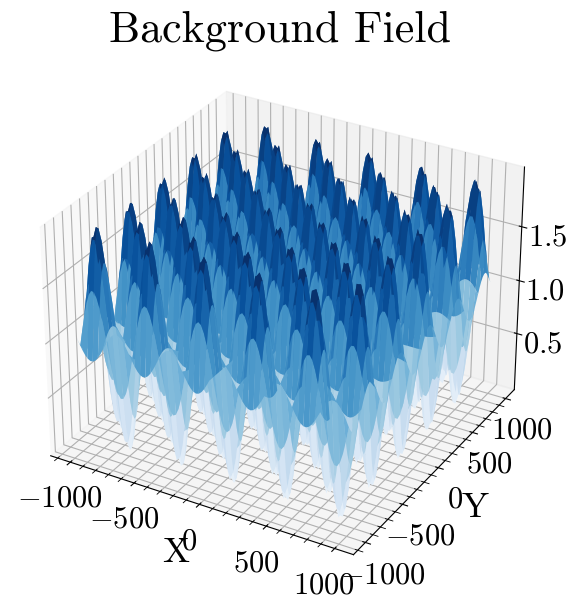

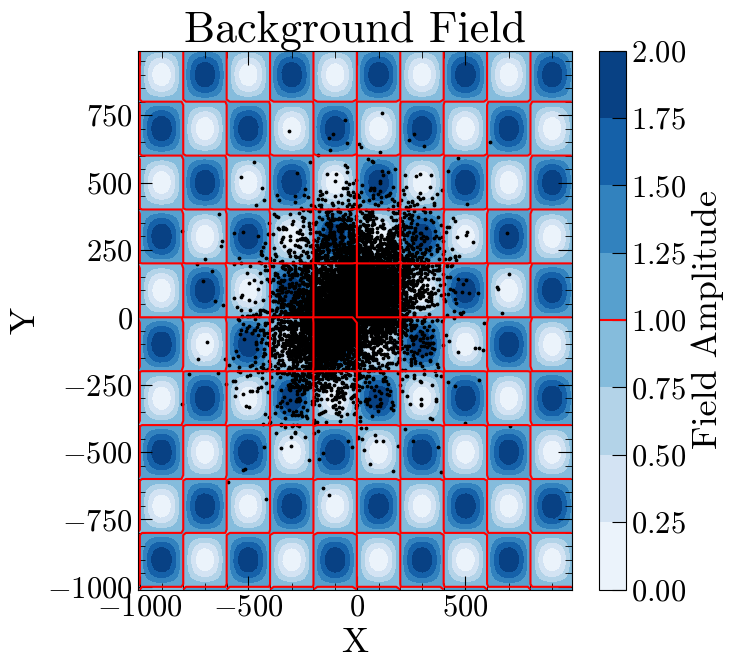

In [17]:
#figure for paper

simulated_wds=get_initial_truth_sample(wd_table,10207 , 1000)
u_sample=simulated_wds['u_init']
v_sample=simulated_wds['v_init']
plot_field(200,0.5,u_sample,v_sample,1000,plot='field',save=True)


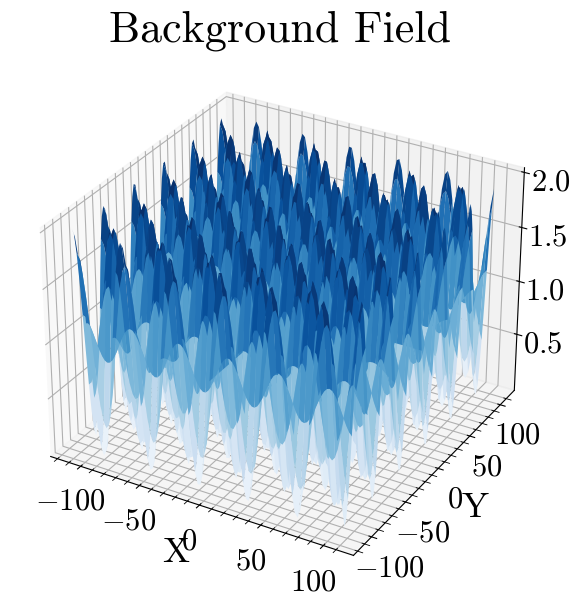

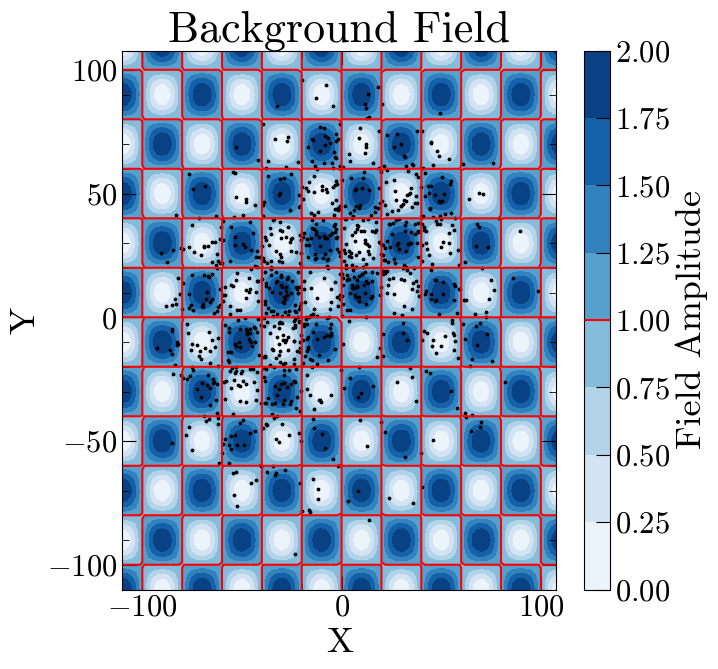

In [18]:
simulated_wds=get_initial_truth_sample(binning_table, sample_size, grid_size)
u_sample=simulated_wds['u_init']
v_sample=simulated_wds['v_init']
plot_field(corr_length,epsilon,u_sample,v_sample,grid_size,plot='field')

In [19]:
#use the Fontaine models and wdtools to define interpolations from thin to thick H models

#thick H atmosphere
font_model_thick = WD_models.load_model('f', 'f', 'f', 'H')

#thin H atmosphere
font_model_thin = WD_models.load_model('ft', 'ft', 'ft', 'H')

#get the WD surface gravity and radius
g_wd_thick = 10**font_model_thick['logg'] 
r_wd_thick = np.sqrt(font_model_thick['mass_array'] * MsunCGS * GCGS/g_wd_thick)/RsunCGS
g_wd_thin = 10**font_model_thin['logg'] 
r_wd_thin = np.sqrt(font_model_thin['mass_array'] * MsunCGS * GCGS/g_wd_thin)/RsunCGS

#given WD mass and teff, what is difference in logg/radius for thick and thin models
thick_mass_teff_to_logg = WD_models.interp_xy_z_func(x = font_model_thick['mass_array'], y =10**font_model_thick['logteff'],\
                                                    z = font_model_thick['logg'] , interp_type = 'linear')
thick_mass_teff_to_rad = WD_models.interp_xy_z_func(x = font_model_thick['mass_array'], y =10**font_model_thick['logteff'],\
                                                    z = r_wd_thick , interp_type = 'linear')
thin_mass_teff_to_logg = WD_models.interp_xy_z_func(x = font_model_thin['mass_array'], y =10**font_model_thin['logteff'],\
                                                    z = font_model_thin['logg'] , interp_type = 'linear')
thin_mass_teff_to_rad = WD_models.interp_xy_z_func(x = font_model_thin['mass_array'], y =10**font_model_thin['logteff'],\
                                                    z = r_wd_thin , interp_type = 'linear')

def thick_to_thin(teff,logg,radius,mass):
    #get difference in thin vs thick model measurements
    logg_corr=thin_mass_teff_to_logg(mass,teff)-thick_mass_teff_to_logg(mass,teff)
    rad_corr=thin_mass_teff_to_rad(mass,teff)-thick_mass_teff_to_rad(mass,teff)
    #correct to thin H layer value
    logg_thin=logg+logg_corr
    radius_thin=radius+rad_corr
    return(logg_thin,radius_thin)

def add_thin_H_envelopes(simulated_wds,plot=False):
    #Take the difference in thin vs thick logg/radius at the given WD mass and temperature.
    #For a random sample of 20%, assume the WD actually has a thin H layer and adjust the true WD logg/radius
    #to the thin H layer value
    #the measured value assumes thick H layers and remains unchanged
    
    #randomly select 20% of the objects
    thin_wds=simulated_wds.sample(frac=0.2)
    
    #change the measured logg/radius to the thin H layer value
    loggs=[]
    radii=[]
    thin_loggs=[]
    thin_radii=[]
    for i in range(len(thin_wds)):
        teff=thin_wds['teff_measured'].to_list()[i]
        logg=thin_wds['logg_measured'].to_list()[i]
        radius=thin_wds['radius_measured'].to_list()[i]
        mass=thin_wds['mass_init'].to_list()[i] #ULDM effect included at fixed mass so real mass is still mass_init
        logg_thin,radius_thin=thick_to_thin(teff,logg,radius,mass)
        loggs.append(logg)
        radii.append(radius)
        thin_loggs.append(logg_thin)
        thin_radii.append(radius_thin)
        
    if plot==True:
        #plot the difference in the parameters
        fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,5))
        ax1.hist(np.array(radii)-np.array(thin_radii), bins='auto', histtype='stepfilled')
        ax1.set_xlabel('(Thick H-Thin H) Radius (Rsun)')
        ax2.hist(np.array(loggs)-np.array(thin_loggs), bins='auto', histtype='stepfilled')
        ax2.set_xlabel('(Thick H-Thin H) Logg (dex)')
        plt.show()
        
    #change values in table
    thin_wds['logg_measured']=thin_loggs
    thin_wds['radius_measured']=thin_radii
    
    #add the thin H sample back to the full sample
    thin_H_indices=thin_wds.index
    for ind in thin_H_indices:
        simulated_wds.loc[ind,'logg_measured']=thin_wds.loc[ind,'logg_measured']
        simulated_wds.loc[ind,'radius_measured']=thin_wds.loc[ind,'radius_measured']

    #drop any nans
    simulated_wds=simulated_wds.dropna(subset=['logg_measured','radius_measured']) #this removes just a few objects, ususally ~10/10,000
    #reset the indices
    indices=np.arange(0,len(simulated_wds))
    simulated_wds.set_index(indices,inplace=True)
    
    return(simulated_wds)

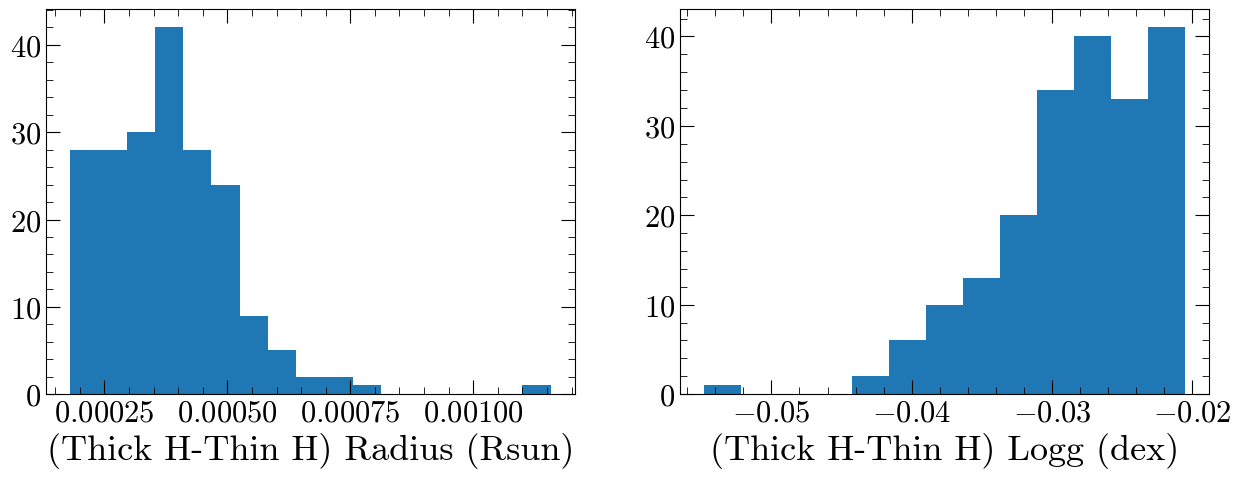

In [20]:
simulated_wds=get_initial_truth_sample(wd_table, sample_size, grid_size)
simulated_wds=add_thin_H_envelopes(simulated_wds,plot=True)


In [21]:
#read in the results from nb03, characterizing the effects of dust on photometric fits
extinction_effect_radius=pd.read_csv('csv/extinction_effect_radius.csv')
extinction_effect_teff=pd.read_csv('csv/extinction_effect_teff.csv')

#re-format the bin range columns into min and max
tables=[extinction_effect_radius,extinction_effect_teff]

for table in tables:
    bin_mins=[]
    bin_maxes=[]
    for i in range(len(table)):
        min_val,max_val=table['bin_range'][i].strip('[]').replace(",", "").split()
        bin_mins.append(float(min_val))
        bin_maxes.append(float(max_val))
    table['bin_min']=bin_mins
    table['bin_max']=bin_maxes

#change the max value to 10
extinction_effect_radius.loc[12, 'bin_max']=10
extinction_effect_teff.loc[12, 'bin_max']=10


In [22]:
def add_dust(simulated_wds,effect_strength,plot=False):
    teff_sample=simulated_wds['teff_measured']
    radius_sample=simulated_wds['radius_measured']
    distance_sample=np.array(simulated_wds['distance_init'].to_list())
    l_sample=np.array(simulated_wds['l_init'].to_list())
    b_sample=np.array(simulated_wds['b_init'].to_list())
    
    #get the reddening at each point
    coords = SkyCoord(frame="galactic", l=l_sample*u.deg, b=b_sample*u.deg, distance = distance_sample*u.pc)
    # Query Edenhofer2023Query to get mean E(B-V) in arbitrary units
    ehq = Edenhofer2023Query(integrated=True) #integrated=True gives integrated extinction from coordinate
    ehq_mean = ehq.query(coords, mode='mean')
    # Convert E to Av
    simulated_wds['av']=2.8*ehq_mean
    #below 69 pc, just set extinction to 0 since very near
    simulated_wds['av']=simulated_wds['av'].fillna(0)
    av_sample=simulated_wds['av'].to_list()
    
    measured_teffs=[]
    measured_radiuss=[]
    for i in range(len(simulated_wds)):
        no_dust_teff=teff_sample[i]
        no_dust_radius=radius_sample[i]
        av_val=av_sample[i]
        
        if av_val==0:
            measured_teff=no_dust_teff
            measured_radius=no_dust_radius
        else:    
            #get the nb03 mean and std difference in measured parameters
            tmp=extinction_effect_radius[(av_val >= extinction_effect_radius['bin_min']) & (av_val < extinction_effect_radius['bin_max'])]
            if len(tmp)==0:
                print('Av does not fall in table range, ', av_val)
                measured_radius=no_dust_radius
            else:
                difference=tmp['med_difference'].to_list()[0]/effect_strength
                measured_radius=no_dust_radius-difference #=dusty radius

            tmp=extinction_effect_teff[(av_val >= extinction_effect_teff['bin_min']) & (av_val < extinction_effect_teff['bin_max'])]
            if len(tmp)==0:
                print('Av does not fall in table range, ', av_val)
                measured_radius=no_dust_radius
            else:
                difference=tmp['med_difference'].to_list()[0]/effect_strength
                measured_teff=no_dust_teff-difference #=dusty teff
        
        measured_teffs.append(measured_teff)
        measured_radiuss.append(measured_radius)
        
    if plot==True:
        #plot the difference in the parameters
        fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,5))
        ax1.hist(np.array(radius_sample)-np.array(measured_radiuss), bins='auto', histtype='stepfilled')
        ax1.set_xlabel('(No Dust-Dust) Radius (Rsun)')
        ax2.hist(np.array(teff_sample)-np.array(measured_teffs), bins='auto', histtype='stepfilled')
        ax2.set_xlabel('(No Dust-Dust) Teff (K)')
        plt.show()
    
    #update the measured parameters with the impact of dust
    simulated_wds['radius_measured']=measured_radiuss
    simulated_wds['teff_measured']=measured_teffs
    
    if plot==True:
        #plot the samples
        fig, (ax1,ax2,ax3) = plt.subplots(1, 3,figsize=(15,5))
        ax1.hist(simulated_wds['av'], alpha=0.3,bins='auto', histtype='stepfilled')
        ax1.set_xlabel('Av Sample (mag)')
        
        ax2.hist(radius_sample, alpha=0.3,bins='auto', histtype='stepfilled',label='No Dust')
        ax2.hist(measured_radiuss, alpha=0.3, bins='auto', histtype='stepfilled',label='Dust')
        ax2.set_xlabel('Radius Sample (Rsun)')
        
        ax3.hist(teff_sample, alpha=0.3, bins='auto', histtype='stepfilled',label='No Dust')
        ax3.hist(measured_teffs, alpha=0.3, bins='auto', histtype='stepfilled',label='Dust')
        ax3.set_xlabel('Teff (K)')
        ax3.legend()
        
        plt.subplots_adjust(wspace = 0.3,hspace=0.4)

        plt.show()
    
    return(simulated_wds)
            

Integrating extinction map (this might take a couple of minutes)...
Optimizing map for querying (this might take a couple of seconds)...


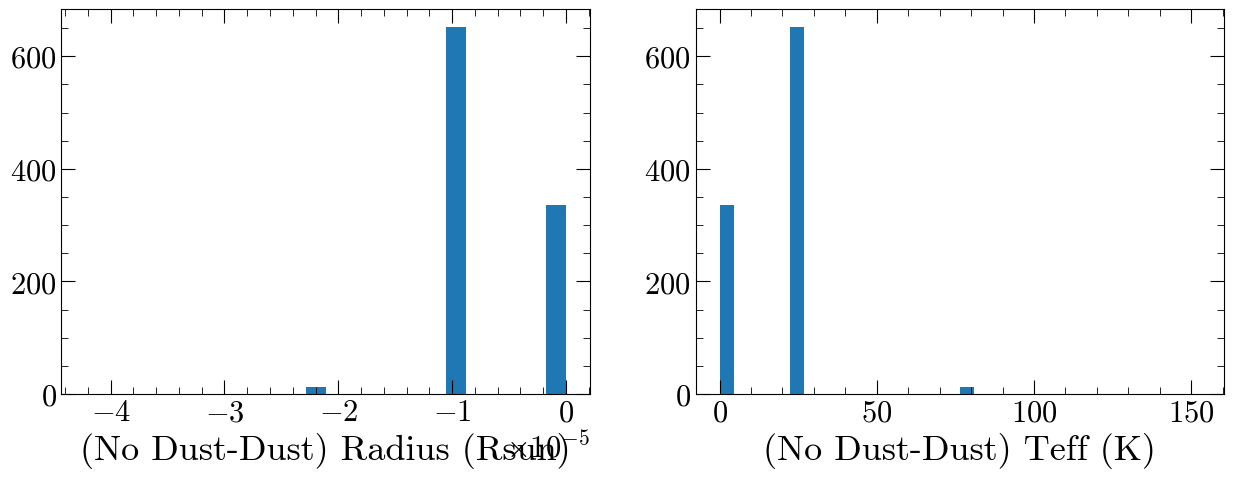

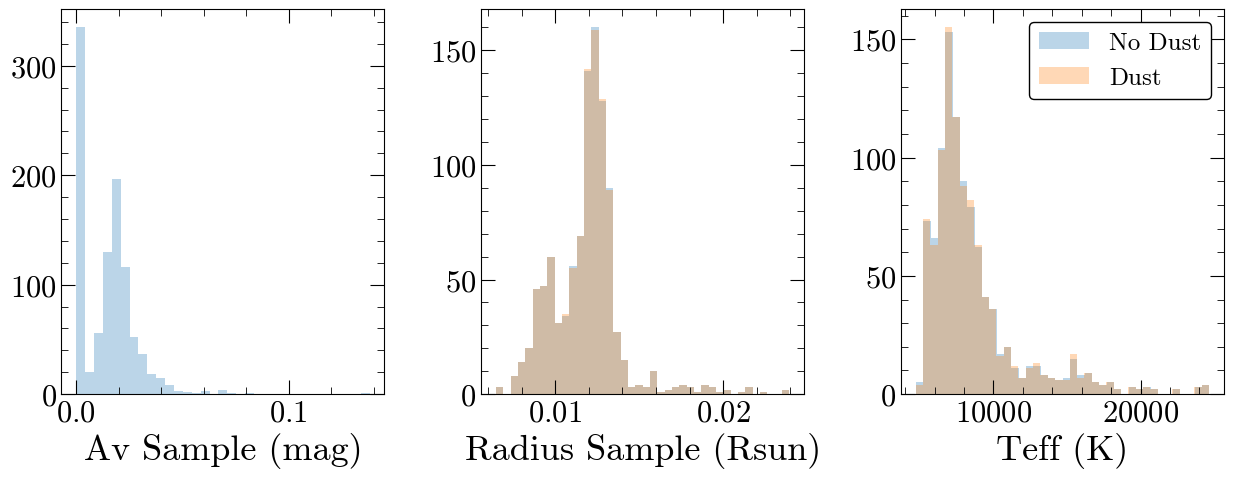

In [23]:
simulated_wds=get_initial_truth_sample(wd_table, sample_size, grid_size)
simulated_wds=add_dust(simulated_wds,effect_strength=10,plot=True)


In [24]:
#read in the results from nb02, characterizing the effects of binaries on spectroscopic and photometric fits
binaries_effect_radius_sdss=pd.read_csv('csv/binaries_effect_radius_sdss.csv')
binaries_effect_teff_sdss=pd.read_csv('csv/binaries_effect_teff_sdss.csv')
binaries_effect_radius_gaia=pd.read_csv('csv/binaries_effect_radius_gaia.csv')
binaries_effect_teff_gaia=pd.read_csv('csv/binaries_effect_teff_gaia.csv')
binaries_effect_logg=pd.read_csv('csv/binaries_effect_logg.csv')

#re-format the bin range columns into min and max
tables=[binaries_effect_radius_sdss,binaries_effect_teff_sdss,binaries_effect_radius_gaia,
        binaries_effect_teff_gaia,binaries_effect_logg]

for table in tables:
    bin_mins=[]
    bin_maxes=[]
    for i in range(len(table)):
        min_val,max_val=table['bin_range'][i].strip('[]').replace(",", "").split()
        bin_mins.append(float(min_val))
        bin_maxes.append(float(max_val))
    table['bin_min']=bin_mins
    table['bin_max']=bin_maxes

#for the radius tables, change the max value to 1
binaries_effect_radius_sdss.loc[12, 'bin_max']=1
binaries_effect_radius_gaia.loc[12, 'bin_max']=1

#for the temperature tables, change the min value to 0 and the max to 200,000
binaries_effect_teff_sdss.loc[0, 'bin_min']=0
binaries_effect_teff_sdss.loc[41, 'bin_max']=200000
binaries_effect_teff_gaia.loc[0, 'bin_min']=0
binaries_effect_teff_gaia.loc[41, 'bin_max']=200000

#for the logg table, change the min value to 0 and the max to 15
binaries_effect_logg.loc[0, 'bin_min']=0
binaries_effect_logg.loc[20, 'bin_max']=15

In [25]:
#what proportion of WDs in my sample can be auto-flagged as likely binaries?
print(len(wd_table.query('mass_rad_theory<0.45')))
print(len(wd_table.query('radius_phot>0.016')))
print(len(wd_table))

794
1349
10207


In [26]:
def add_binaries(simulated_wds,chance_companion=0.05,plot=False):
    mass_sample=simulated_wds['mass_init']
    teff_sample=simulated_wds['teff_measured']
    radius_sample=simulated_wds['radius_measured']
    logg_sample=simulated_wds['logg_measured']
    
    measured_teffs=[]
    measured_radiuss=[]
    measured_loggs=[]
    
    diff_teffs=[]
    diff_radiuss=[]
    diff_loggs=[]
    
    num_binaries=0
    for i in range(len(mass_sample)):
        primary_mass=mass_sample[i]
        primary_teff=teff_sample[i]
        primary_radius=radius_sample[i]
        primary_logg=logg_sample[i]
        #for any object in the drawn sample with mass<0.45 Msun (He WDs), P(companion)=1
        if primary_mass<0.45:
            companion=True
        #all other objects in the drawn sample, P(companion)=chance_companion
        #set chance_companion=0.01, 0.05, or 0.1 for 1%, 5%, or 10% chance as motivated by the literature
        else:
            if np.random.uniform(0,1) <= chance_companion:
                companion=True
            else:
                companion=False
                
        #if the WD has a companion, get the measured properties of the system from nb02
        if companion==True:
            num_binaries+=1
            
            #get the nb04 median difference in measured parameters            
            tmp=binaries_effect_radius_sdss[(primary_radius >= binaries_effect_radius_sdss['bin_min']) & (primary_radius < binaries_effect_radius_sdss['bin_max'])]
            if len(tmp)==0:
                print('Radius does not fall in binaries_effect_radius_sdss range, ', primary_radius)
                measured_radius_sdss=primary_radius
            else:
                #print('binaries_effect_radius_sdss',primary_radius,mean,std)
                difference=tmp['med_difference'].to_list()[0]
                measured_radius_sdss=primary_radius-difference
            
            tmp=binaries_effect_teff_sdss[(primary_teff >= binaries_effect_teff_sdss['bin_min']) & (primary_teff < binaries_effect_teff_sdss['bin_max'])]
            if len(tmp)==0:
                print('Teff does not fall in binaries_effect_teff_sdss range, ', primary_teff)
                measured_teff_sdss=primary_teff
            else:
                #print('binaries_effect_teff_sdss',primary_teff,mean,std)
                difference=tmp['med_difference'].to_list()[0]
                measured_teff_sdss=primary_teff-difference
            
            tmp=binaries_effect_radius_gaia[(primary_radius >= binaries_effect_radius_gaia['bin_min']) & (primary_radius < binaries_effect_radius_gaia['bin_max'])]
            if len(tmp)==0:
                print('Radius does not fall in binaries_effect_radius_gaia range, ', primary_radius)
                measured_radius_gaia=primary_radius
            else:
                #print('binaries_effect_radius_gaia',primary_radius,mean,std)
                difference=tmp['med_difference'].to_list()[0]
                measured_radius_gaia=primary_radius-difference
            
            tmp=binaries_effect_teff_gaia[(primary_teff >= binaries_effect_teff_gaia['bin_min']) & (primary_teff < binaries_effect_teff_gaia['bin_max'])]
            if len(tmp)==0:
                print('Teff does not fall in binaries_effect_teff_gaia range, ', primary_teff)
                measured_teff_gaia=primary_teff
            else:
                #print('binaries_effect_teff_gaia',primary_teff,mean,std)
                difference=tmp['med_difference'].to_list()[0]
                measured_teff_gaia=primary_teff-difference
            
            tmp=binaries_effect_logg[(primary_logg >= binaries_effect_logg['bin_min']) & (primary_logg < binaries_effect_logg['bin_max'])]
            #print('binaries_effect_logg',primary_logg,mean,std)
            difference=tmp['med_difference'].to_list()[0]
            measured_logg=primary_logg-difference
            
            #take average of impact from Gaia and SDSS photometry
            measured_radius=(measured_radius_sdss+measured_radius_gaia)/2
            measured_teff=(measured_teff_sdss+measured_teff_gaia)/2
            
            diff_teffs.append(primary_teff-measured_teff)
            diff_radiuss.append(primary_radius-measured_radius)
            diff_loggs.append(primary_logg-measured_logg)
        else:
            measured_radius=primary_radius
            measured_teff=primary_teff
            measured_logg=primary_logg
        
        measured_teffs.append(measured_teff)
        measured_radiuss.append(measured_radius)
        measured_loggs.append(measured_logg)
        
    if plot==True:
        #plot the difference in the parameters
        fig, (ax1,ax2,ax3) = plt.subplots(1, 3,figsize=(20,5))
        ax1.hist(diff_radiuss, bins='auto', histtype='stepfilled')
        ax1.set_xlabel('(No Binary-Binary) Radius (Rsun)')
        ax2.hist(diff_teffs, bins='auto', histtype='stepfilled')
        ax2.set_xlabel('(No Binary-Binary) Teff (K)')
        ax3.hist(diff_loggs, bins='auto', histtype='stepfilled')
        ax3.set_xlabel('(No Binary-Binary) Logg (dex)')
        plt.show()
    
    
    #update the measured parameters with the impact of binaries
    simulated_wds['radius_measured']=measured_radiuss
    simulated_wds['teff_measured']=measured_teffs
    simulated_wds['logg_measured']=measured_loggs
    
    print('Total Binary Contamination Proportion= ',num_binaries/len(mass_sample))
    
    if plot==True:
        #plot the samples
        fig, (ax1,ax2,ax3) = plt.subplots(1, 3,figsize=(15,5))
        ax1.hist(radius_sample, alpha=0.3,bins='auto', histtype='stepfilled',label='No Binaries')
        ax1.hist(measured_radiuss, alpha=0.3, bins='auto', histtype='stepfilled',label='Binaries')
        ax1.set_xlabel('Radius Sample (Rsun)')
        
        ax2.hist(logg_sample, alpha=0.3, bins='auto', histtype='stepfilled',label='No Binaries')
        ax2.hist(measured_loggs, alpha=0.3, bins='auto', histtype='stepfilled',label='Binaries')
        ax2.set_xlabel('Logg Sample (dex)')
        
        ax3.hist(teff_sample, alpha=0.3, bins='auto', histtype='stepfilled',label='No Binaries')
        ax3.hist(measured_teffs, alpha=0.3, bins='auto', histtype='stepfilled',label='Binaries')
        ax3.set_xlabel('Teff (K)')
        ax3.legend()
        
        plt.subplots_adjust(wspace = 0.3,hspace=0.4)

        plt.show()
    
    return(simulated_wds)
            

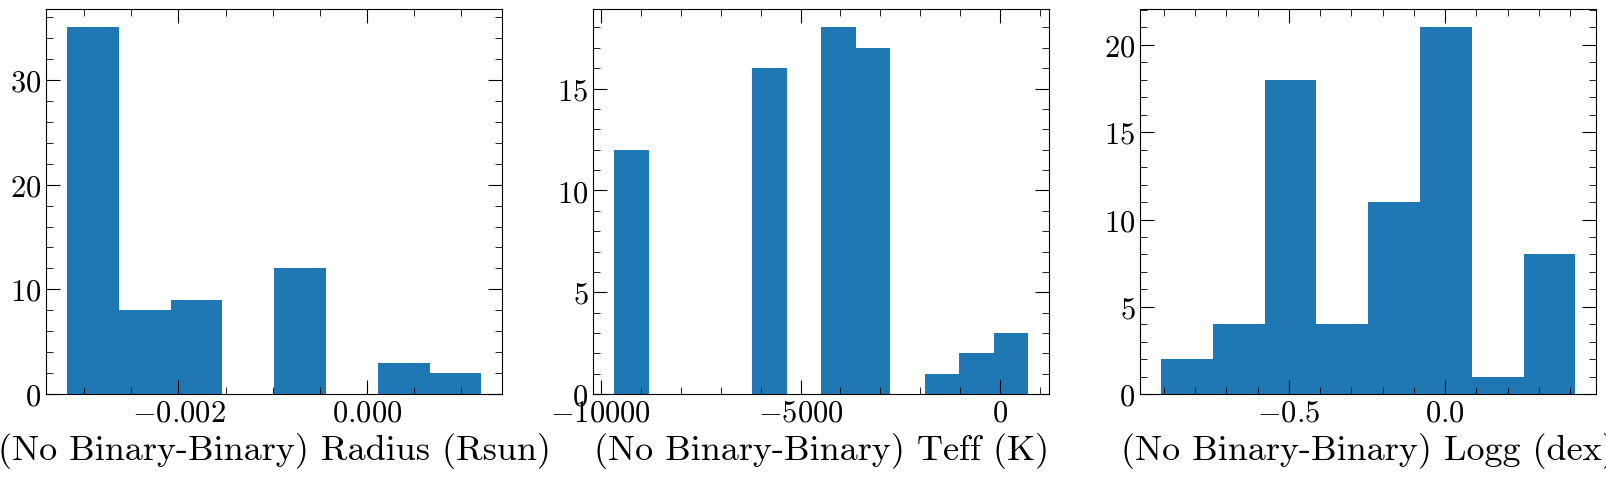

Total Binary Contamination Proportion=  0.069


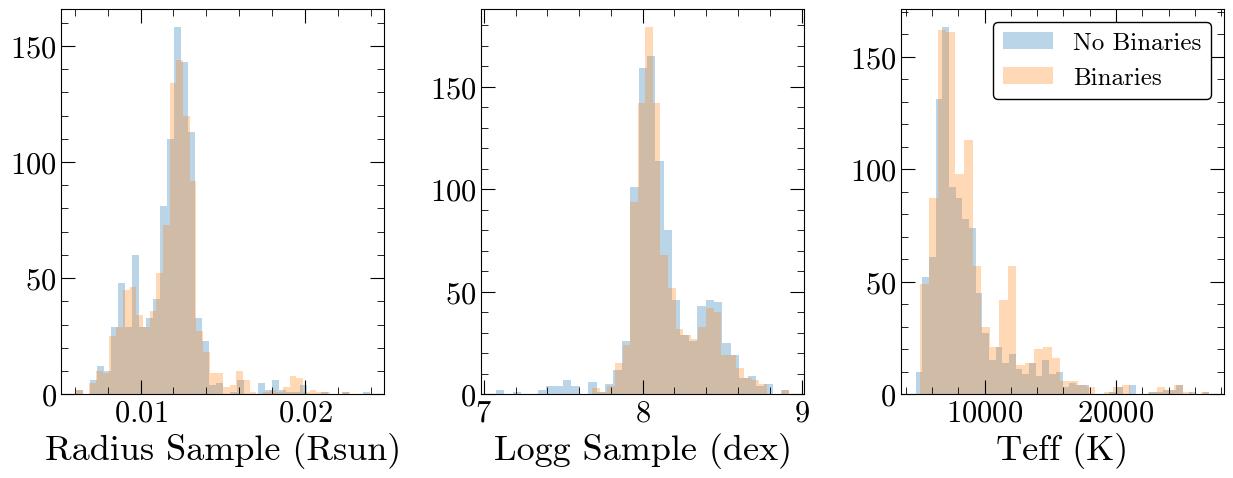

In [27]:
simulated_wds=get_initial_truth_sample(wd_table, sample_size, grid_size)
chance_companion=0.05
simulated_wds=add_binaries(simulated_wds,chance_companion,plot=True)


In [28]:
#read in the results from above, characterizing the dependence of measurement and distance noise on distance
e_dist_dist=pd.read_csv('csv/e_dist_dist.csv')
e_radius_dist=pd.read_csv('csv/e_radius_dist.csv')
e_teff_dist=pd.read_csv('csv/e_teff_dist.csv')
e_logg_dist=pd.read_csv('csv/e_logg_dist.csv')

#re-format the bin range columns into min and max
tables=[e_dist_dist,e_radius_dist,e_teff_dist,e_logg_dist]
for table in tables:
    bin_mins=[]
    bin_maxes=[]
    for i in range(len(table)):
        min_val,max_val=table['bin_range'][i].strip('[]').replace(",", "").split()
        bin_mins.append(float(min_val))
        bin_maxes.append(float(max_val))
    table['bin_min']=bin_mins
    table['bin_max']=bin_maxes


In [29]:
def add_distance_noise(simulated_wds,grid_size,plot=False):
    #this function draws a noisy coordinate sample
    #computed with noise=median error+nsigma_noise*std from our measured data
    #assume the noise in the location of the WD is dominated by the distance uncertainty

    distance_sample=simulated_wds['distance_init']
    l_sample=np.array(simulated_wds['l_init'].to_list())
    b_sample=np.array(simulated_wds['b_init'].to_list())
    
    noisy_distance_sample=[]
    for i in range(len(simulated_wds)):
        init_dist=distance_sample[i]
        tmp=e_dist_dist[(init_dist >= e_dist_dist['bin_min']) & (init_dist < e_dist_dist['bin_max'])]
        if len(tmp)==0:
            print('Dist does not fall in table range, ', init_dist)
            noisy_dist=init_dist
        else:
            #make a sample of noisy distance measurements where the noise is a gaussian centered at 0 multiplied by the
            #distance noise parameter, which is set by the median error from the measured distances
            dist_noise_med=tmp['med'].to_list()[0]
            dist_noise=dist_noise_med
            noisy_dist = init_dist + dist_noise * np.random.normal(size = 1)
        noisy_distance_sample.append(noisy_dist[0])
    noisy_distance_sample=np.array(noisy_distance_sample)
        
    #if distance is > grid_size, reflect it back to be within range (ie. 110 becomes 90 for grid_size=100)
    too_far= (noisy_distance_sample > grid_size)
    noisy_distance_sample[too_far]=grid_size-(noisy_distance_sample[too_far]-grid_size)
    #if distance is negative, take absolute value
    negative = (noisy_distance_sample < 0.029)
    noisy_distance_sample[negative]=np.abs(noisy_distance_sample[negative])
    
    #convert l, b, and distance (which are in galactic coordinates) to a cartesian representation
    coords_cartesian=SkyCoord(l=l_sample*u.deg, 
                              b=b_sample*u.deg, 
                              distance=noisy_distance_sample*u.pc,
                              frame='galactic')
    coords_cartesian.representation_type = 'cartesian'
    noisy_u_sample=coords_cartesian.u.value
    noisy_v_sample=coords_cartesian.v.value
    noisy_w_sample=coords_cartesian.w.value
    
    #update measured coordinates with noise
    simulated_wds['distance_measured']=noisy_distance_sample
    simulated_wds['u_measured']=noisy_u_sample
    simulated_wds['v_measured']=noisy_v_sample
    simulated_wds['w_measured']=noisy_w_sample
    
    if plot==True:
        #plot the difference in the parameters
        fig, (ax1) = plt.subplots(1, 1,figsize=(7,5))
        ax1.hist(np.array(distance_sample)-np.array(noisy_distance_sample), bins='auto', histtype='stepfilled')
        ax1.set_xlabel('(No Noise-Noise) Distance (pc)')
        plt.show()
    
    if plot==True:
        #plot the samples
        fig, (ax1) = plt.subplots(1, 1,figsize=(5,5))
        
        ax1.hist(distance_sample, alpha=0.3, bins='auto', histtype='stepfilled',label='True')
        ax1.hist(noisy_distance_sample, alpha=0.3, bins='auto', histtype='stepfilled',label='Noisy')
        ax1.set_xlabel('Distance Sample (pc)')

        plt.show()
    
    return(simulated_wds)


In [30]:
table=wd_table
np.nanmedian(table['r_hi_geo']-table['r_lo_geo'])

20.976898193359375

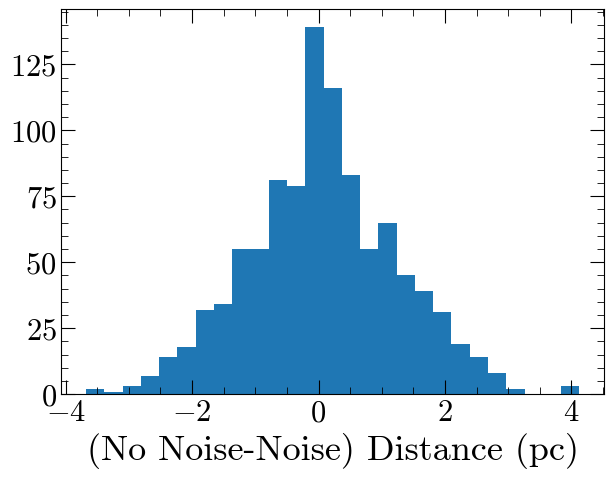

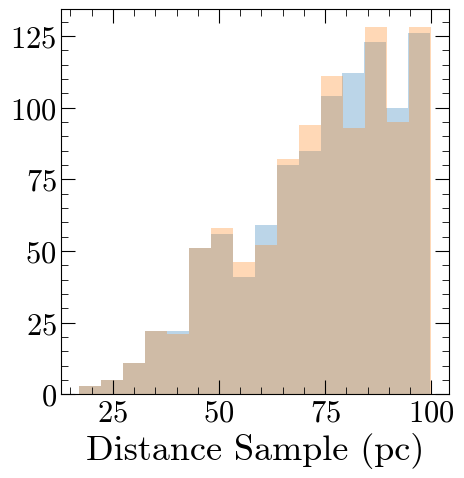

In [31]:
simulated_wds=get_initial_truth_sample(binning_table, sample_size, grid_size)
simulated_wds=add_distance_noise(simulated_wds,grid_size,plot=True)


In [32]:
def add_measurement_noise(simulated_wds,improvement_factor,plot=False):
    #this function draws a noisy radius, logg, and temperature samples
    #computed with noise=median error+nsigma_noise*std from our measured data
    #where the median error depends on the WD distance
    
    teff_sample=simulated_wds['teff_measured']
    radius_sample=simulated_wds['radius_measured']
    logg_sample=simulated_wds['logg_measured']
    distance_sample=simulated_wds['distance_init']

    noisy_teff_sample=[]
    noisy_radius_sample=[]
    noisy_logg_sample=[]
    for i in range(len(simulated_wds)):
        init_teff=teff_sample[i]
        init_radius=radius_sample[i]
        init_logg=logg_sample[i]
        dist_val=distance_sample[i]
        
        tmp=e_radius_dist[(dist_val >= e_radius_dist['bin_min']) & (dist_val < e_radius_dist['bin_max'])]
        if len(tmp)==0:
            print('Dist does not fall in table range, ', dist_val)
            noisy_radius=init_radius
        else:
            radius_noise_med=tmp['med'].to_list()[0]
            radius_noise=radius_noise_med/improvement_factor
            noisy_radius = init_radius + radius_noise * np.random.normal(size = 1)
        
        tmp=e_teff_dist[(dist_val >= e_teff_dist['bin_min']) & (dist_val < e_teff_dist['bin_max'])]
        if len(tmp)==0:
            print('Dist does not fall in table range, ', dist_val)
            noisy_teff=init_teff
        else:
            teff_noise_med=tmp['med'].to_list()[0]
            teff_noise=teff_noise_med/improvement_factor
            noisy_teff = init_teff + teff_noise * np.random.normal(size = 1)
            
        tmp=e_logg_dist[(dist_val >= e_logg_dist['bin_min']) & (dist_val < e_logg_dist['bin_max'])]
        if len(tmp)==0:
            print('Dist does not fall in table range, ', dist_val)
            noisy_logg=init_logg
        else:
            logg_noise_med=tmp['med'].to_list()[0]
            logg_noise=logg_noise_med/improvement_factor
            noisy_logg = init_logg + logg_noise * np.random.normal(size = 1)

        noisy_teff_sample.append(noisy_teff[0])
        noisy_radius_sample.append(noisy_radius[0])
        noisy_logg_sample.append(noisy_logg[0])
        
    #update measured parameters with noise
    simulated_wds['teff_measured']=noisy_teff_sample
    simulated_wds['radius_measured']=noisy_radius_sample
    simulated_wds['logg_measured']=noisy_logg_sample

    if plot==True:
        #plot the difference in the parameters
        fig, (ax1,ax2,ax3) = plt.subplots(1, 3,figsize=(20,5))
        ax1.hist(np.array(radius_sample)-np.array(noisy_radius_sample), bins='auto', histtype='stepfilled')
        ax1.set_xlabel('(No Noise-Noise) Radius (Rsun)')
        ax2.hist(np.array(teff_sample)-np.array(noisy_teff_sample), bins='auto', histtype='stepfilled')
        ax2.set_xlabel('(No Noise-Noise) Teff (K)')
        ax3.hist(np.array(logg_sample)-np.array(noisy_logg_sample), bins='auto', histtype='stepfilled')
        ax3.set_xlabel('(No Noise-Noise) Logg (dex)')
        plt.show()
    
    if plot==True:
        #plot the samples
        fig, (ax1,ax2,ax3) = plt.subplots(1, 3,figsize=(15,5))
        ax1.hist(radius_sample, alpha=0.3,bins='auto', histtype='stepfilled',label='No Noise')
        ax1.hist(noisy_radius_sample, alpha=0.3, bins='auto', histtype='stepfilled',label='Noise')
        ax1.set_xlabel('Radius Sample (Rsun)')
        
        ax2.hist(logg_sample, alpha=0.3, bins='auto', histtype='stepfilled',label='No Noise')
        ax2.hist(noisy_logg_sample, alpha=0.3, bins='auto', histtype='stepfilled',label='Noise')
        ax2.set_xlabel('Logg Sample (dex)')
        
        ax3.hist(teff_sample, alpha=0.3, bins='auto', histtype='stepfilled',label='No Noise')
        ax3.hist(noisy_teff_sample, alpha=0.3, bins='auto', histtype='stepfilled',label='Noise')
        ax3.set_xlabel('Teff (K)')
        ax3.legend()
        
        plt.subplots_adjust(wspace = 0.3,hspace=0.4)

        plt.show()
    
    return(simulated_wds)


In [33]:
table=wd_table
print(np.nanmedian(table['e_radius_phot_full']))
print(np.nanmedian(table['e_logg_prf_coadd_full']))
print(np.nanmedian(table['e_teff_phot_full']))

0.0015470255655752
0.1221381210649384
987.8847310540856


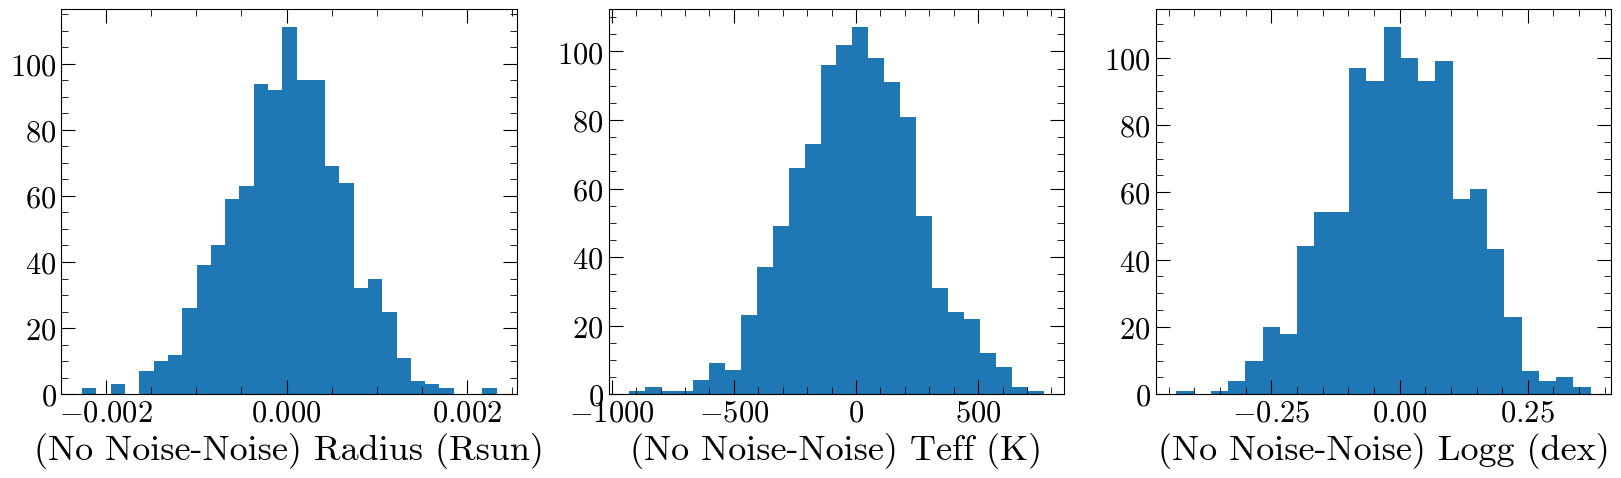

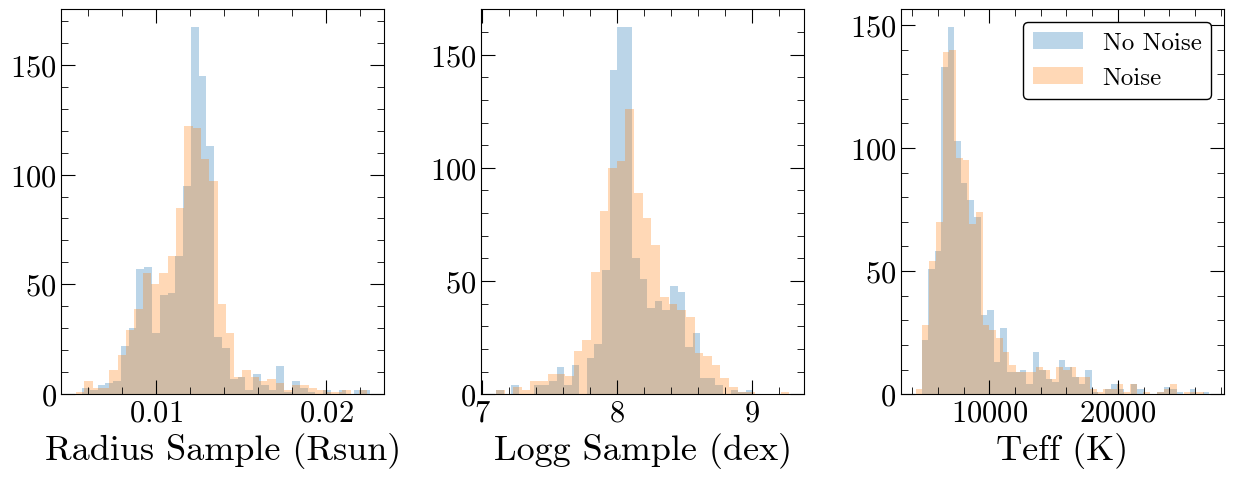

In [34]:
improvement_factor=1 #use median noise

simulated_wds=get_initial_truth_sample(binning_table, sample_size, grid_size)
simulated_wds=add_measurement_noise(simulated_wds,improvement_factor,plot=True)


## Calculate Moran's I Statistic at variety of distance cuts

First, add the measured masses to the data frame. The mass is obtained by combining the measured radius with the measured logg (so does not assume any MR relation).

$$M(R,\log{g})=gR^2/G=10^{\log{g}}R^2/G$$
$$\delta M(R,\log{g})=\frac{10^{\log{g}}R}{G}\sqrt{4\delta R^2+(R\ln{10})^2\delta(\log{g})^2}$$


In [35]:
def add_measured_masses(simulated_wds):
    radii=simulated_wds['radius_measured']
    loggs=simulated_wds['logg_measured']
    
    #compute the mass in solar units given measured radius and logg
    masses=[]
    #convert radii from solar units to CGS units
    radii=radii*RsunCGS
    #get the surface gravity
    gs=10**(loggs)
    for i in range(len(radii)):
        M=(gs[i]*(radii[i]**2)/GCGS)/MsunCGS
        masses.append(M)
        
    simulated_wds['mass_measured']=masses
    return(simulated_wds)


In [36]:
simulated_wds=add_measured_masses(simulated_wds)

In [55]:
def MoransI_contributions(simulated_wds,sample_size,epsilon,corr_length,noise_label,improvement_factor,effect_strength,chance_companion,remove_likely_binaries,max_len=100000):
    #this function calculates the contribution to Moran's I from each pair
    
    #now only inputs are the measured values which might differ from the true values
    ucoords=simulated_wds['u_measured']
    vcoords=simulated_wds['v_measured']
    wcoords=simulated_wds['w_measured']
    mass=simulated_wds['mass_measured']
    radius=simulated_wds['radius_measured']
    teff=simulated_wds['teff_measured']
    
    #get difference between expected radius from theory+measured mass+measured teff and measured radius with dme variation
    theory_radius = radius_from_mass_teff(mass, teff)
    deviation=theory_radius-radius
    med_abs_deviation=np.median(np.abs(deviation))
    
    #set maximum length of resulting i+j DataFrames to break up into pieces
    #otherwise can overwhelm memory when applying to >10,000 WDs
    #don't set maximum length for i dataframe since we have a max of 20,000 WDs anyways
    
    #path to save outputs
    if corr_length==0 and epsilon==0:
        path='csv/nb04_sample_size_'+str(sample_size)+'/No_Dark_Matter/'+noise_label+'_'+str(improvement_factor)+'_'+str(effect_strength)+'_'+str(chance_companion)+'_'+str(remove_likely_binaries)+'/tmp/'
    else:
        path='csv/nb04_sample_size_'+str(sample_size)+'/'+noise_label+'_'+str(improvement_factor)+'_'+str(effect_strength)+'_'+str(chance_companion)+'_'+str(remove_likely_binaries)+'/ep_'+str(epsilon)+'_corr_'+str(corr_length)+'/'
    
    #make directory if does not exist
    try:
        os.makedirs(path)
    except:
        pass
    
    #make data frames both for when summing over each WD
    #and for when summing over each WD pair
    contributions_df_isum=pd.DataFrame()
    contributions_df_ijsum=pd.DataFrame()
    
    #compute N
    N=len(ucoords)
        
    #the expected deviation is 0 for dme=0, could also take mean of all deviations
    xbar=0
    
    #compute contributions, assuming weight=1
    #we will implement distance cuts later to calculate values as function of separation
    num_dfs_ijsum=1
    
    Ns=[]
    i_vals_ionly=[]
    denom_MI_conts=[]
    numerator_s3_conts=[]
    denom_s3_conts=[]
    
    i_vals=[]
    j_vals=[]
    separations=[]
    W_conts=[]
    numerator_MI_conts=[]
    s1_conts=[]
    s2_conts=[]
    
    for i in tqdm(range(N)):
        #record N and median absolute deviation
        Ns.append(N)

        #record WD index
        i_vals_ionly.append(i)

        #record Moran's I contributions
        denom_MI_conts.append((deviation[i]-xbar)**2)

        #record Z-score contributions
        numerator_s3_conts.append((deviation[i]-xbar)**4)
        denom_s3_conts.append((deviation[i]-xbar)**2)

    #save output
    contributions_df_isum['N']=Ns
    contributions_df_isum['i']=i_vals_ionly
    contributions_df_isum['denom_MI_cont']=denom_MI_conts
    contributions_df_isum['numerator_s3_cont']=numerator_s3_conts
    contributions_df_isum['denom_s3_cont']=denom_s3_conts
    contributions_df_isum.to_csv(path+'contributions_df_isum.csv',index=False)        
    
    current_len=0
    for i in tqdm(range(N)):
        for j in range(N):
            current_len+=1
            
            #record pair indices
            i_vals.append(i)
            j_vals.append(j)
            
            #record distance between WDs
            u1=ucoords[i]
            v1=vcoords[i]
            w1=wcoords[i]
            u2=ucoords[j]
            v2=vcoords[j]
            w2=wcoords[j]
            separations.append(np.sqrt((u1-u2)**2+(v1-v2)**2+(w1-w2)**2))
            
            #record W contribution
            W_conts.append(1)
            
            #record Moran's I contributions
            numerator_MI_conts.append((deviation[i]-xbar)*(deviation[j]-xbar))
            
            #record Z-score contributions
            s1_conts.append((1+1)**2)
            s2_conts.append((1+1)**2)
            
            #if have multiple of max_len rows then save current list in dataframe and .csv
            if current_len%max_len==0 and current_len!=0:
                #save results
                contributions_df_ijsum['i']=i_vals
                contributions_df_ijsum['j']=j_vals
                contributions_df_ijsum['separation']=separations
                contributions_df_ijsum['W_cont']=W_conts
                contributions_df_ijsum['numerator_MI_cont']=numerator_MI_conts
                contributions_df_ijsum['s1_cont']=s1_conts
                contributions_df_ijsum['s2_cont']=s2_conts
                contributions_df_ijsum.to_csv(path+'contributions_df_ijsum_'+str(num_dfs_ijsum)+'.csv',index=False)
                #record that are starting new DataFrame
                num_dfs_ijsum+=1
                #empty lists and DataFrame
                i_vals=[]
                j_vals=[]
                separations=[]
                W_conts=[]
                numerator_MI_conts=[]
                s1_conts=[]
                s2_conts=[]
                contributions_df_ijsum=pd.DataFrame()
    #whenever finish loop, also save output
    contributions_df_ijsum['i']=i_vals
    contributions_df_ijsum['j']=j_vals
    contributions_df_ijsum['separation']=separations
    contributions_df_ijsum['W_cont']=W_conts
    contributions_df_ijsum['numerator_MI_cont']=numerator_MI_conts
    contributions_df_ijsum['s1_cont']=s1_conts
    contributions_df_ijsum['s2_cont']=s2_conts
    contributions_df_ijsum.to_csv(path+'contributions_df_ijsum_'+str(num_dfs_ijsum)+'.csv',index=False)

    return(path,num_dfs_ijsum,med_abs_deviation,current_len)


In [38]:
max_len=500000
path,num_dfs_ijsum,med_abs_deviation,tot_len=MoransI_contributions(simulated_wds,sample_size,epsilon,corr_length,'test','test','test','test','test')


100%|███████████████████████████████████████| 1000/1000 [00:12<00:00, 80.46it/s]


In [39]:
def MoransI_calculation(path,num_dfs_ijsum,distance_cuts):
    #this function calculates Moran's I at various distance cuts
    
    Ws=[]
    moransIs=[]
    expectations=[]
    variances=[]
    zscores=[]
    for d_cut in distance_cuts:
        #calculate each parameter by summing over the DataFrames
        
        #sums over individual WDs
        denom_MI=0
        numerator_s3=0
        denom_s3=0
        contributions_df_isum=pd.read_csv(path+'contributions_df_isum.csv')
        denom_MI+=contributions_df_isum['denom_MI_cont'].sum()
        numerator_s3=contributions_df_isum['numerator_s3_cont'].sum()
        denom_s3=contributions_df_isum['denom_s3_cont'].sum()
        
        #sums over WD pairs
        W=0
        s1=0
        s2=0
        numerator_MI=0
        for j in range(num_dfs_ijsum):
            contributions_df_ijsum=pd.read_csv(path+'contributions_df_ijsum_'+str(j+1)+'.csv')
            
            #keep only distances within the cut and drop any rows where i=j, this enforces the weight matrix
            apply_weights_df=contributions_df_ijsum.query('separation<=@d_cut and i!=j')
            
            W+=float(apply_weights_df['W_cont'].sum())
            numerator_MI+=apply_weights_df['numerator_MI_cont'].sum()
            s1+=apply_weights_df['s1_cont'].sum()
            s2+=apply_weights_df['s2_cont'].sum()
        
        
        N=float(contributions_df_isum.iloc[0]['N'])
        
        try:
            #Moran's I
            moransI=(N/W)*(numerator_MI/denom_MI)

            #expectation value
            expectation=-1/(N-1)

            #variance
            s1=(1/2)*s1
            s3=((1/N)*numerator_s3)/(((1/N)*denom_s3)**2)
            s4=(N**2-3*N+3)*s1-(N*s2)+(3*(W**2))
            s5=(N**2-N)*s1-(2*N*s2)+(6*(W**2))
            expect_Isqr=(N*s4-s3*s5)/((N-1)*(N-2)*(N-3)*(W**2))
            var=expect_Isqr-expectation**2

            #Z-score
            zscore=(moransI-expectation)/np.sqrt(var)
        except:
            moransI=np.nan
            expectation=np.nan
            var=np.nan
            zscore=np.nan
        
        #save results
        Ws.append(W)
        moransIs.append(moransI)
        expectations.append(expectation)
        variances.append(var)
        zscores.append(zscore)
        
    return(Ws,moransIs, expectations, variances,zscores)

In [40]:
d=100
MoransI_calculation(path,num_dfs_ijsum,[d])


([626166.0],
 [0.016801881559936005],
 [-0.001001001001001001],
 [5.173989472004108e-06],
 [7.82667962007826])

In [41]:
#calculate for range of distances from d=1 pc to order of magnitude of grid_size
max_exp=floor(log10(abs(grid_size)))
distances=np.logspace(0,max_exp,num=50)

Ws,moransIs, expectations, variances,zscores=MoransI_calculation(path,num_dfs_ijsum,distances)


20.0 1.93069772888325


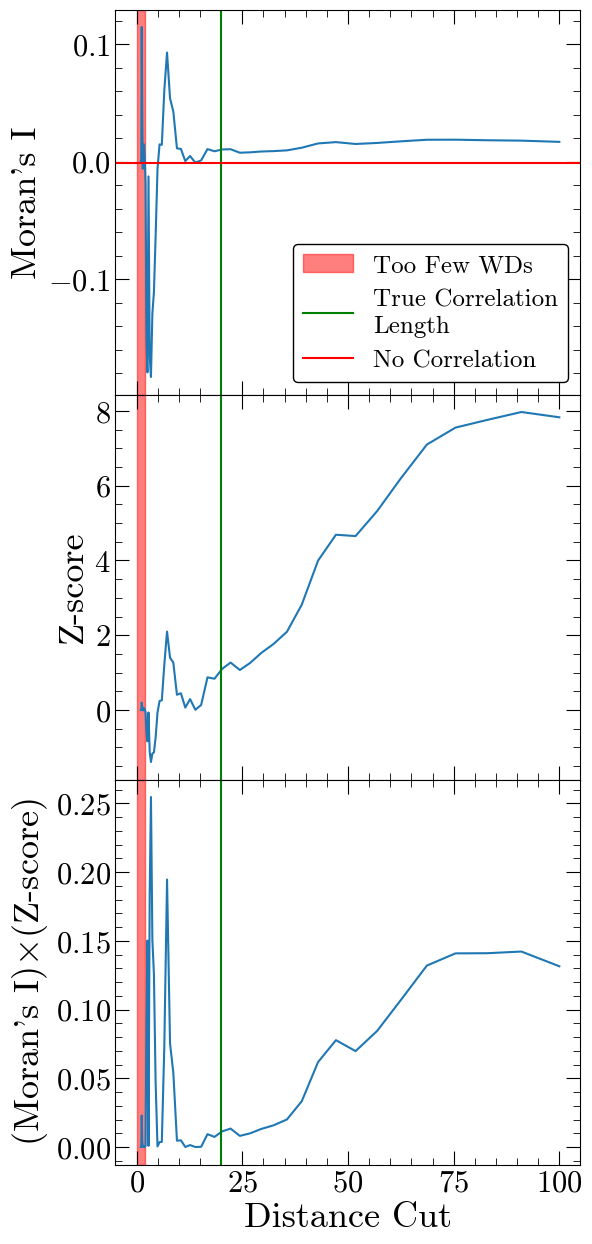

In [42]:
#plot

#cut to make sure have enough nonzero weights for valid results
nonzero_weight_cut=20
index = bisect_left(Ws, nonzero_weight_cut)
print(Ws[index],distances[index])

fig, ((ax1),(ax2),(ax3)) = plt.subplots(3,1,figsize=(6,15),sharex=True)
ax1.plot(distances,moransIs)
ax1.axvspan(0,distances[index],color='red',alpha=0.5,label='Too Few WDs')
ax1.axvline(corr_length,color='green',label='True Correlation\nLength')
ax1.axhline(expectations[0],color='red',label='No Correlation')
ax1.set_ylabel("Moran's I")
ax1.legend()

ax2.axvspan(0,distances[index],color='red',alpha=0.5,label='Too Few WDs')
ax2.plot(distances,zscores)
ax2.axvline(corr_length,color='green')
ax2.set_ylabel('Z-score')

mult=[]
for i in range(len(moransIs)):
    mult.append(moransIs[i]*zscores[i])

ax3.axvspan(0,distances[index],color='red',alpha=0.5,label='Too Few WDs')
ax3.plot(distances,mult)
ax3.axvline(corr_length,color='green')
ax3.set_xlabel('Distance Cut')
ax3.set_ylabel(r"(Moran's I)$\times$(Z-score)")

plt.subplots_adjust(wspace = 0,hspace=0)

# Put everything together and investigate the effects of different noise and contamination sources

In [52]:
def full_simulation(corr_length,epsilon,sample_size,grid_size,distances,
                    chance_companion,improvement_factor,effect_strength,noise_effect_array,remove_likely_binaries,iternum=None):
    
    #noise effect array tells which noise sources to turn on
    #'0'=off, '1'=on
    thin_H,dust,binaries,measurement_noise,distance_uncertainty=noise_effect_array
    noise_label="".join(noise_effect_array)
    
    #check if simulation exists
    try:
        if corr_length==0 and epsilon==0:
            npzfile = np.load('csv/nb04_sample_size_'+str(sample_size)+'/No_Dark_Matter/'+noise_label+'_'+str(improvement_factor)+'_'+str(effect_strength)+'_'+str(chance_companion)+'_'+str(remove_likely_binaries)+'/ep_'+str(epsilon)+'_corr_'+str(corr_length)+str(iternum)+'.npz')
        else:
            npzfile = np.load('csv/nb04_sample_size_'+str(sample_size)+'/'+noise_label+'_'+str(improvement_factor)+'_'+str(effect_strength)+'_'+str(chance_companion)+'_'+str(remove_likely_binaries)+'/ep_'+str(epsilon)+'_corr_'+str(corr_length)+str(iternum)+'.npz')
    
    except:
        #get truth sample
        simulated_wds=get_initial_truth_sample(binning_table,sample_size,grid_size)

        #add thin H envelope contamination if desired
        if thin_H=='1':
            print('Adding thin H envelope contamination')
            simulated_wds=add_thin_H_envelopes(simulated_wds)
        
        #get electron mass variation sample
        #if you don't want to include ULDM, set corr_length=epsilon=0
        if corr_length==0 and epsilon==0:
            print('No dark matter')
        else:
            simulated_wds=get_mass_variation_sample(corr_length,epsilon,simulated_wds)
        
        #add dust if desired
        if dust=='1':
            print('Adding dust')
            simulated_wds=add_dust(simulated_wds,effect_strength)
        
        #add binaries if desired
        if binaries=='1':
            print('Adding binary contamination')
            simulated_wds=add_binaries(simulated_wds,chance_companion)
        
        #add measurement noise if desired
        if measurement_noise=='1':
            print('Adding measurement noise')
            simulated_wds=add_measurement_noise(simulated_wds,improvement_factor)
        
        #add distance uncertainty if desired
        if distance_uncertainty=='1':
            print('Adding distance uncertainty')
            simulated_wds=add_distance_noise(simulated_wds,grid_size)
        
        #add the measured masses with any desired noise sources
        simulated_wds=add_measured_masses(simulated_wds)
        
        #remove objects which must be binaries (according to measured radius), if desired
        if remove_likely_binaries=='1':
            print('Dropping any WD with measured radius>0.016 (low mass WDs)')
            init_len=len(simulated_wds)
            simulated_wds=simulated_wds.query('radius_measured<0.016')
            #reset the indices
            indices=np.arange(0,len(simulated_wds))
            simulated_wds.set_index(indices,inplace=True)
            final_len=len(simulated_wds)
            print('Dropped ',(final_len/init_len)*100,' % of objects')
        
        #get contributions of each WD pair to Moran's I
        path,num_dfs_ijsum,med_abs_deviation,tot_len=MoransI_contributions(simulated_wds,sample_size,epsilon,corr_length,noise_label,improvement_factor,effect_strength,chance_companion,remove_likely_binaries)

        #calculate Moran's I for range of distances 
        Ws,moransIs, expectations, variances,zscores=MoransI_calculation(path,num_dfs_ijsum,distances)

        #write the data in a txt file
        if corr_length==0 and epsilon==0:
            np.savez('csv/nb04_sample_size_'+str(sample_size)+'/No_Dark_Matter/'+noise_label+'_'+str(improvement_factor)+'_'+str(effect_strength)+'_'+str(chance_companion)+'_'+str(remove_likely_binaries)+'/ep_'+str(epsilon)+'_corr_'+str(corr_length)+str(iternum),Ws=Ws,med_abs_deviations=med_abs_deviation, distances=distances,moransIs=moransIs,expectations=expectations,variances=variances,zscores=zscores)  
        else:
            np.savez('csv/nb04_sample_size_'+str(sample_size)+'/'+noise_label+'_'+str(improvement_factor)+'_'+str(effect_strength)+'_'+str(chance_companion)+'_'+str(remove_likely_binaries)+'/ep_'+str(epsilon)+'_corr_'+str(corr_length)+str(iternum),Ws=Ws,med_abs_deviations=med_abs_deviation, distances=distances,moransIs=moransIs,expectations=expectations,variances=variances,zscores=zscores)  

        #delete the intermediate files
        shutil.rmtree(path)

In [44]:
def get_output(corr_length,epsilon,sample_size,chance_companion,improvement_factor,effect_strength,noise_effect_array,remove_likely_binaries,
               no_dark_matter=False,iternum=None,nonzero_weight_cut=20,plot=True):
    #read back in measurements
    noise_label="".join(noise_effect_array)
    if no_dark_matter:
        npzfile = np.load('csv/nb04_sample_size_'+str(sample_size)+'/No_Dark_Matter/'+noise_label+'_'+str(improvement_factor)+'_'+str(effect_strength)+'_'+str(chance_companion)+'_'+str(remove_likely_binaries)+'/ep_'+str(epsilon)+'_corr_'+str(corr_length)+str(iternum)+'.npz')
    else:
        npzfile = np.load('csv/nb04_sample_size_'+str(sample_size)+'/'+noise_label+'_'+str(improvement_factor)+'_'+str(effect_strength)+'_'+str(chance_companion)+'_'+str(remove_likely_binaries)+'/ep_'+str(epsilon)+'_corr_'+str(corr_length)+str(iternum)+'.npz')
    med_abs_deviations = npzfile['med_abs_deviations']
    Ws = npzfile['Ws']
    final_distances = npzfile['distances']
    moransIs = npzfile['moransIs'] 
    expectations = npzfile['expectations']
    variances = npzfile['variances']
    zscores = npzfile['zscores']
    
    mult=[]
    for i in range(len(moransIs)):
        mult.append(moransIs[i]*zscores[i])
        
    #cut to make sure have enough nonzero weights for valid results
    index = bisect_left(Ws, nonzero_weight_cut)
    
    if plot:
        #plot
        fig, ((ax1),(ax2),(ax3)) = plt.subplots(3,1,figsize=(6,15),sharex=True)
        ax1.plot(final_distances,moransIs)
        ax1.axvspan(0,final_distances[index],color='red',alpha=0.5,label='Too Few WDs')
        ax1.axvline(corr_length,color='green',label='True Correlation\nLength')
        ax1.axhline(expectations[0],color='red',label='No Correlation')
        ax1.set_ylabel("Moran's I")
        ax1.legend()

        ax2.plot(final_distances,zscores)
        ax2.axvspan(0,final_distances[index],color='red',alpha=0.5,label='Too Few WDs')
        ax2.axvline(corr_length,color='green')
        ax2.set_ylabel('Z-score')

        ax3.plot(final_distances,mult)
        ax3.axvspan(0,final_distances[index],color='red',alpha=0.5,label='Too Few WDs')
        ax3.axvline(corr_length,color='green')
        ax3.set_xlabel('Distance Cut')
        ax3.set_ylabel(r"(Moran's I)$\times$(Z-score)")

        plt.subplots_adjust(wspace = 0,hspace=0)
        plt.show()
    
    return(final_distances,med_abs_deviations,Ws,moransIs,expectations,variances,zscores,mult,index)


In [ ]:
sample_size=10207
grid_size=1000
#distance cut array
distances=np.array([1,3,6,9,12,15,18,21,24,27,30,35,40,45,50,55,60,70,80,90,100,125,150,175,200,225,250,275,300,325,350,375,400,
                            425,450,475,500,550,600,650,700,750,800,850,900,1000])

corr_length=300 #pc
epsilon=0.1 #max me variation

noise_effect_array=['1','1','1','1','1']
chance_companion=0.01
improvement_factor=10
effect_strength=10
remove_likely_binaries='1' #remove low mass objects


full_simulation(corr_length,epsilon,sample_size,grid_size,distances,chance_companion,improvement_factor,effect_strength,
            noise_effect_array,remove_likely_binaries)
output=get_output(corr_length,epsilon,sample_size,chance_companion,improvement_factor,effect_strength,noise_effect_array,
              remove_likely_binaries)

# Next steps
- Move to Rockfish and simulate these curves for sample_size=10207 for different combinations of noise sources
- Then, in the next set of notebooks, characterize for what values of correlation lengths and epsilon can the correlation length be reconstructed using a CNN for each of the noise scenarios

# list of simulations to run

- 0: no noise sources with dark matter,
- each 1 noise source turned on with dark matter
   - 1: just thin H, 
   - 2: just dust with effect_strength=1, 
   - 3: just dust with effect_strength=10, 
   - 4: just binaries where remove likely binaries, 
   - 5: just measurement noise with improvement_factor=1, 
   - 6: just measurement noise with improvement_factor=10, 
   - 7: just distance noise, 
- 8: all noise sources turned on for median measurement noise (improvement_factor=1),full dust strength (effect_strength=1), remove likely binaries, with dark matter
- 9: all noise sources turned on where reduce measurement noise by order of magnitude (improvement_factor=10), remove likely binaries, with dark matter, 
- 10: all noise sources turned on with improvement_factor=1, where reduce dust effect by order of magnitude (effect_strength=10), remove likely binaries, with dark matter, 
- 11: all noise sources turned on where reduce measurement noise and dust strength by order of magnitude (improvement_factor=10, effect_strength=10), remove likely binaries, with dark matter, 


# No dark matter simulations for sample_size=10207

In [60]:
sample_size=10207
grid_size=1000
#distance cut array
distances=np.array([1,3,6,9,12,15,18,21,24,27,30,35,40,45,50,55,60,70,80,90,100,125,150,175,200,225,250,275,300,325,350,375,400,
                            425,450,475,500,550,600,650,700,750,800,850,900,1000])

#no dark matter
corr_length=0 #pc
epsilon=0 #max me variation


all effects, no ULDM
Adding thin H envelope contamination
No dark matter
Adding dust


Integrating extinction map (this might take a couple of minutes)...
Optimizing map for querying (this might take a couple of seconds)...


Adding binary contamination
Teff does not fall in binaries_effect_teff_sdss range,  -2389.672951988512
Teff does not fall in binaries_effect_teff_gaia range,  -2389.672951988512
Teff does not fall in binaries_effect_teff_sdss range,  -46.856257971854575
Teff does not fall in binaries_effect_teff_gaia range,  -46.856257971854575
Teff does not fall in binaries_effect_teff_sdss range,  -2579.6679253796146
Teff does not fall in binaries_effect_teff_gaia range,  -2579.6679253796146
Teff does not fall in binaries_effect_teff_sdss range,  -1264.6563554955137
Teff does not fall in binaries_effect_teff_gaia range,  -1264.6563554955137
Teff does not fall in binaries_effect_teff_sdss range,  -3776.4302832112526
Teff does not fall in binaries_effect_teff_gaia range,  -3776.4302832112526
Teff does not fall in binaries_effect_teff_sdss range,  -3971.1031524875716
Teff does not fall in binaries_effect_teff_gaia range,  -3971.1031524875716
Teff does not fall in binaries_effect_teff_sdss range,  -3848.

100%|███████████████████████████████████████| 8169/8169 [13:29<00:00, 10.09it/s]


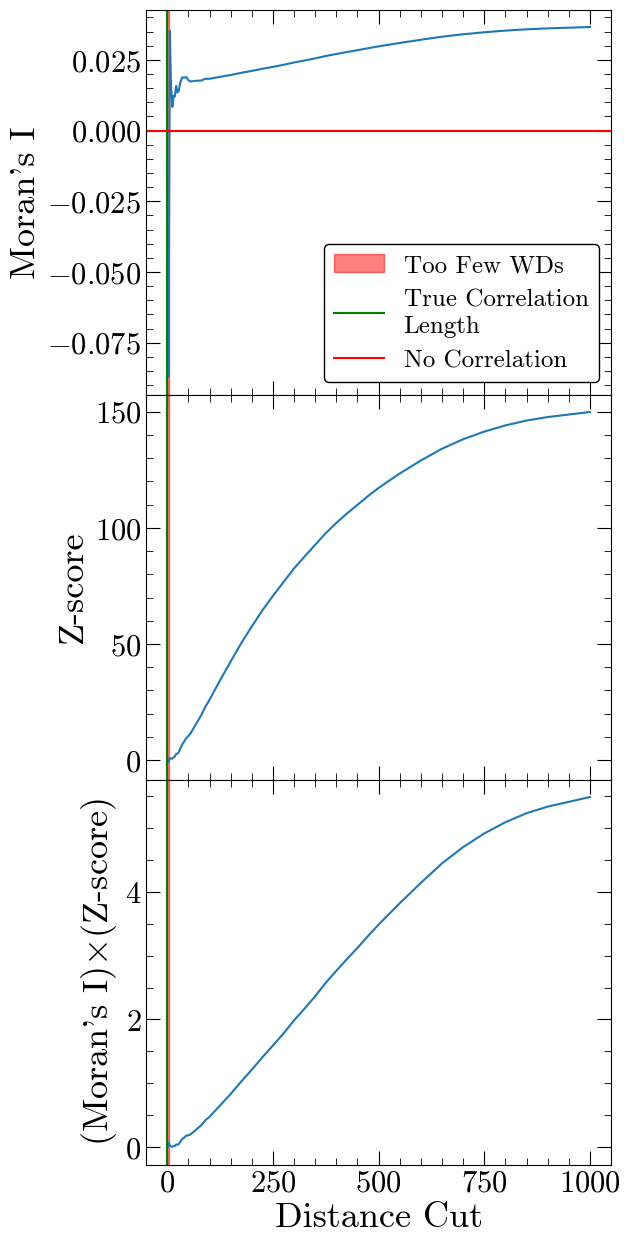

Adding thin H envelope contamination
No dark matter
Adding dust


Integrating extinction map (this might take a couple of minutes)...
Optimizing map for querying (this might take a couple of seconds)...


Adding binary contamination
Teff does not fall in binaries_effect_teff_sdss range,  -741.3900734940635
Teff does not fall in binaries_effect_teff_gaia range,  -741.3900734940635
Teff does not fall in binaries_effect_teff_sdss range,  -2530.3381898870866
Teff does not fall in binaries_effect_teff_gaia range,  -2530.3381898870866
Teff does not fall in binaries_effect_teff_sdss range,  -2522.2670466943227
Teff does not fall in binaries_effect_teff_gaia range,  -2522.2670466943227
Teff does not fall in binaries_effect_teff_sdss range,  -885.4124864595651
Teff does not fall in binaries_effect_teff_gaia range,  -885.4124864595651
Teff does not fall in binaries_effect_teff_sdss range,  -1148.6052585533962
Teff does not fall in binaries_effect_teff_gaia range,  -1148.6052585533962
Teff does not fall in binaries_effect_teff_sdss range,  -4003.7416375023504
Teff does not fall in binaries_effect_teff_gaia range,  -4003.7416375023504
Teff does not fall in binaries_effect_teff_sdss range,  -1544.94

100%|███████████████████████████████████████| 8090/8090 [13:01<00:00, 10.35it/s]


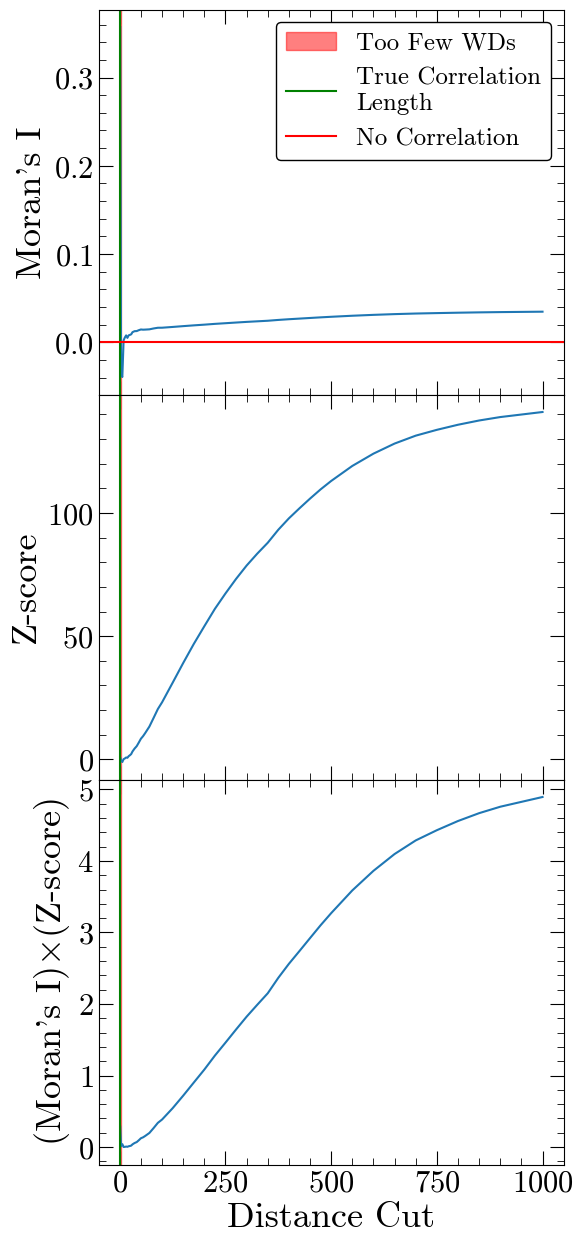

Adding thin H envelope contamination
No dark matter
Adding dust


Integrating extinction map (this might take a couple of minutes)...
Optimizing map for querying (this might take a couple of seconds)...


Adding binary contamination
Teff does not fall in binaries_effect_teff_sdss range,  -1333.1659897626196
Teff does not fall in binaries_effect_teff_gaia range,  -1333.1659897626196
Teff does not fall in binaries_effect_teff_sdss range,  -3379.4863888763875
Teff does not fall in binaries_effect_teff_gaia range,  -3379.4863888763875
Teff does not fall in binaries_effect_teff_sdss range,  -3106.701538289597
Teff does not fall in binaries_effect_teff_gaia range,  -3106.701538289597
Teff does not fall in binaries_effect_teff_sdss range,  -3176.1947895555013
Teff does not fall in binaries_effect_teff_gaia range,  -3176.1947895555013
Teff does not fall in binaries_effect_teff_sdss range,  -208.50097394282966
Teff does not fall in binaries_effect_teff_gaia range,  -208.50097394282966
Teff does not fall in binaries_effect_teff_sdss range,  -1754.73695225347
Teff does not fall in binaries_effect_teff_gaia range,  -1754.73695225347
Teff does not fall in binaries_effect_teff_sdss range,  -3207.6004

100%|███████████████████████████████████████| 8080/8080 [13:01<00:00, 10.34it/s]


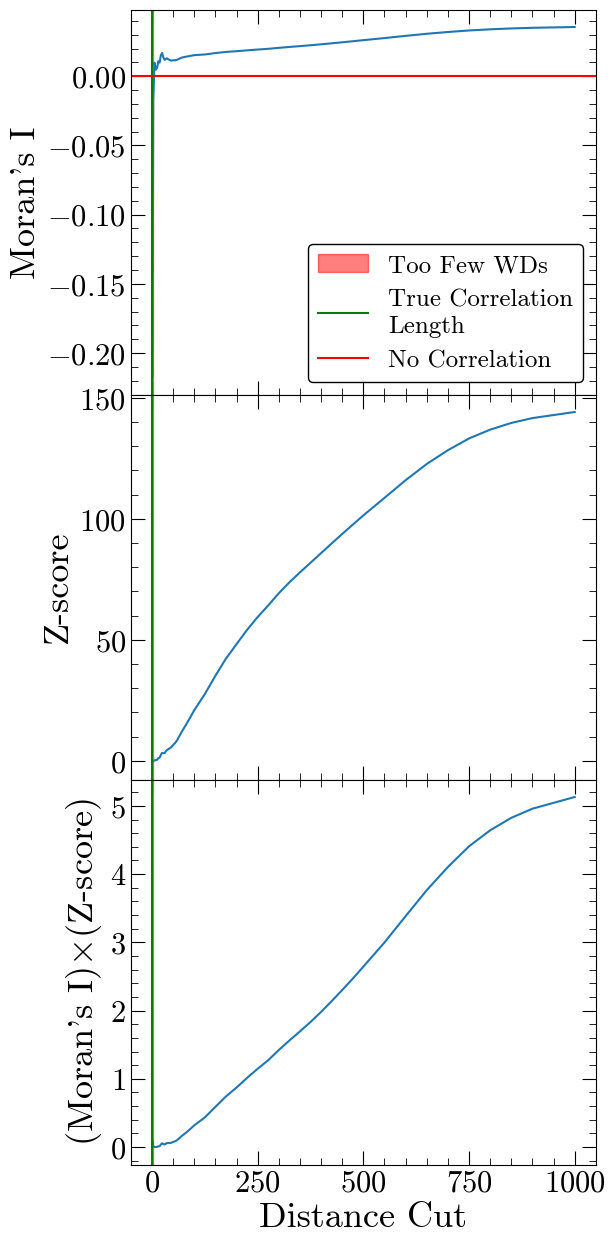

Adding thin H envelope contamination
No dark matter
Adding dust


Integrating extinction map (this might take a couple of minutes)...
Optimizing map for querying (this might take a couple of seconds)...


Adding binary contamination
Teff does not fall in binaries_effect_teff_sdss range,  -4124.203371935209
Teff does not fall in binaries_effect_teff_gaia range,  -4124.203371935209
Teff does not fall in binaries_effect_teff_sdss range,  -3075.4694710154035
Teff does not fall in binaries_effect_teff_gaia range,  -3075.4694710154035
Teff does not fall in binaries_effect_teff_sdss range,  -3816.1596323687945
Teff does not fall in binaries_effect_teff_gaia range,  -3816.1596323687945
Teff does not fall in binaries_effect_teff_sdss range,  -1231.2711266682581
Teff does not fall in binaries_effect_teff_gaia range,  -1231.2711266682581
Teff does not fall in binaries_effect_teff_sdss range,  -200.2904948206251
Teff does not fall in binaries_effect_teff_gaia range,  -200.2904948206251
Teff does not fall in binaries_effect_teff_sdss range,  -1237.8388081745761
Teff does not fall in binaries_effect_teff_gaia range,  -1237.8388081745761
Teff does not fall in binaries_effect_teff_sdss range,  -1219.27

100%|███████████████████████████████████████| 8114/8114 [13:10<00:00, 10.27it/s]


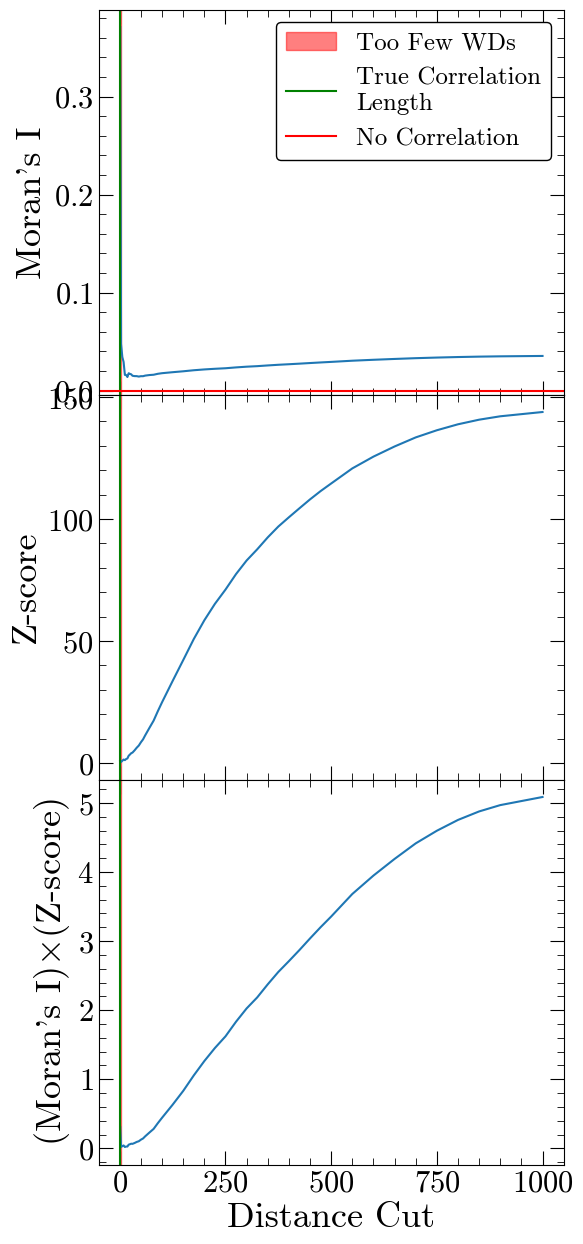

Adding thin H envelope contamination
No dark matter
Adding dust


Integrating extinction map (this might take a couple of minutes)...
Optimizing map for querying (this might take a couple of seconds)...


Adding binary contamination
Teff does not fall in binaries_effect_teff_sdss range,  -2818.0602323376734
Teff does not fall in binaries_effect_teff_gaia range,  -2818.0602323376734
Teff does not fall in binaries_effect_teff_sdss range,  -3982.608493227168
Teff does not fall in binaries_effect_teff_gaia range,  -3982.608493227168
Teff does not fall in binaries_effect_teff_sdss range,  -83.52359546959815
Teff does not fall in binaries_effect_teff_gaia range,  -83.52359546959815
Teff does not fall in binaries_effect_teff_sdss range,  -3252.96809715949
Teff does not fall in binaries_effect_teff_gaia range,  -3252.96809715949
Teff does not fall in binaries_effect_teff_sdss range,  -2889.938002572171
Teff does not fall in binaries_effect_teff_gaia range,  -2889.938002572171
Teff does not fall in binaries_effect_teff_sdss range,  -3940.314480231971
Teff does not fall in binaries_effect_teff_gaia range,  -3940.314480231971
Teff does not fall in binaries_effect_teff_sdss range,  -624.21734615097

100%|███████████████████████████████████████| 8149/8149 [13:07<00:00, 10.35it/s]


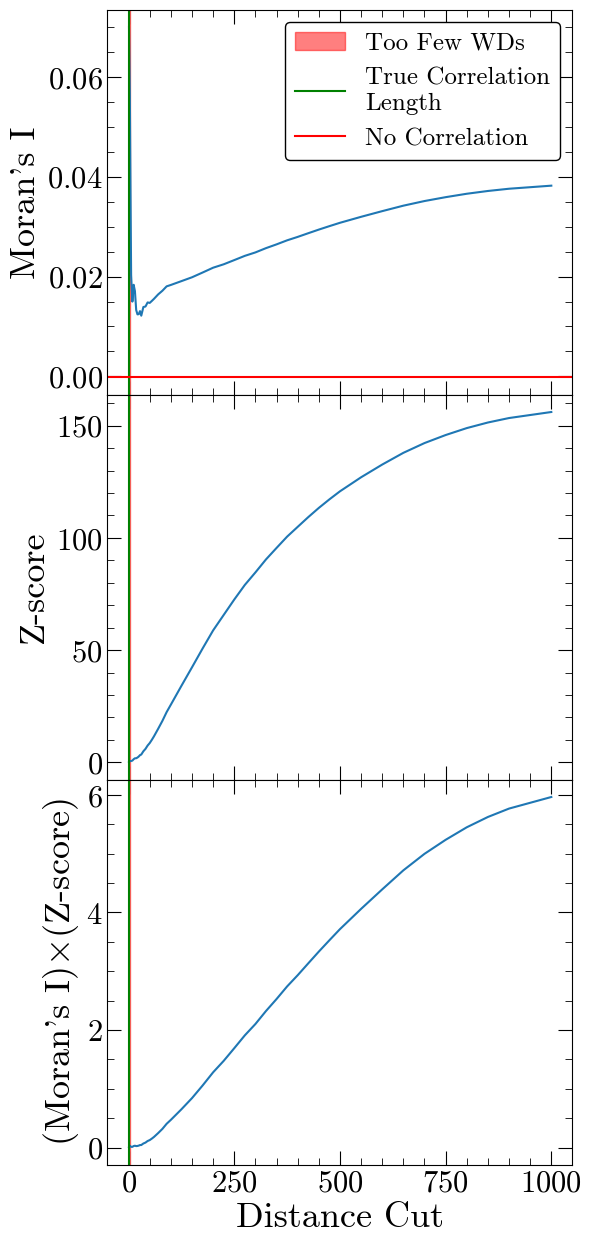

Adding thin H envelope contamination
No dark matter
Adding dust


Integrating extinction map (this might take a couple of minutes)...
Optimizing map for querying (this might take a couple of seconds)...


Adding binary contamination
Teff does not fall in binaries_effect_teff_sdss range,  -1243.1995863635639
Teff does not fall in binaries_effect_teff_gaia range,  -1243.1995863635639
Total Binary Contamination Proportion=  0.08713977651440893
Adding measurement noise
Adding distance uncertainty
Dropping any WD with measured radius>0.016 (low mass WDs)
Dropped  79.64124681435013  % of objects


100%|███████████████████████████████████████| 8125/8125 [13:14<00:00, 10.23it/s]


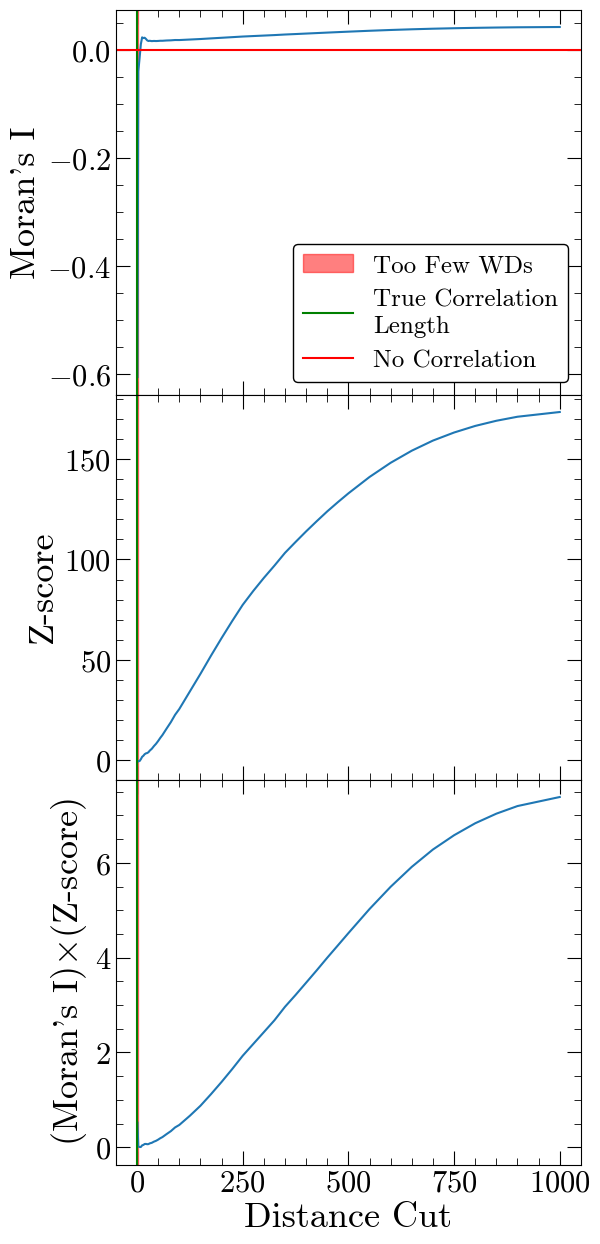

Adding thin H envelope contamination
No dark matter
Adding dust


Integrating extinction map (this might take a couple of minutes)...
Optimizing map for querying (this might take a couple of seconds)...


Adding binary contamination
Teff does not fall in binaries_effect_teff_sdss range,  -354.1632288906694
Teff does not fall in binaries_effect_teff_gaia range,  -354.1632288906694
Teff does not fall in binaries_effect_teff_sdss range,  -1865.3366426387183
Teff does not fall in binaries_effect_teff_gaia range,  -1865.3366426387183
Teff does not fall in binaries_effect_teff_sdss range,  -4347.9513077676465
Teff does not fall in binaries_effect_teff_gaia range,  -4347.9513077676465
Teff does not fall in binaries_effect_teff_sdss range,  -2384.8509766217758
Teff does not fall in binaries_effect_teff_gaia range,  -2384.8509766217758
Teff does not fall in binaries_effect_teff_sdss range,  -86.46174913454342
Teff does not fall in binaries_effect_teff_gaia range,  -86.46174913454342
Teff does not fall in binaries_effect_teff_sdss range,  -837.2099343553946
Teff does not fall in binaries_effect_teff_gaia range,  -837.2099343553946
Teff does not fall in binaries_effect_teff_sdss range,  -3385.2862

100%|███████████████████████████████████████| 8148/8148 [12:43<00:00, 10.67it/s]


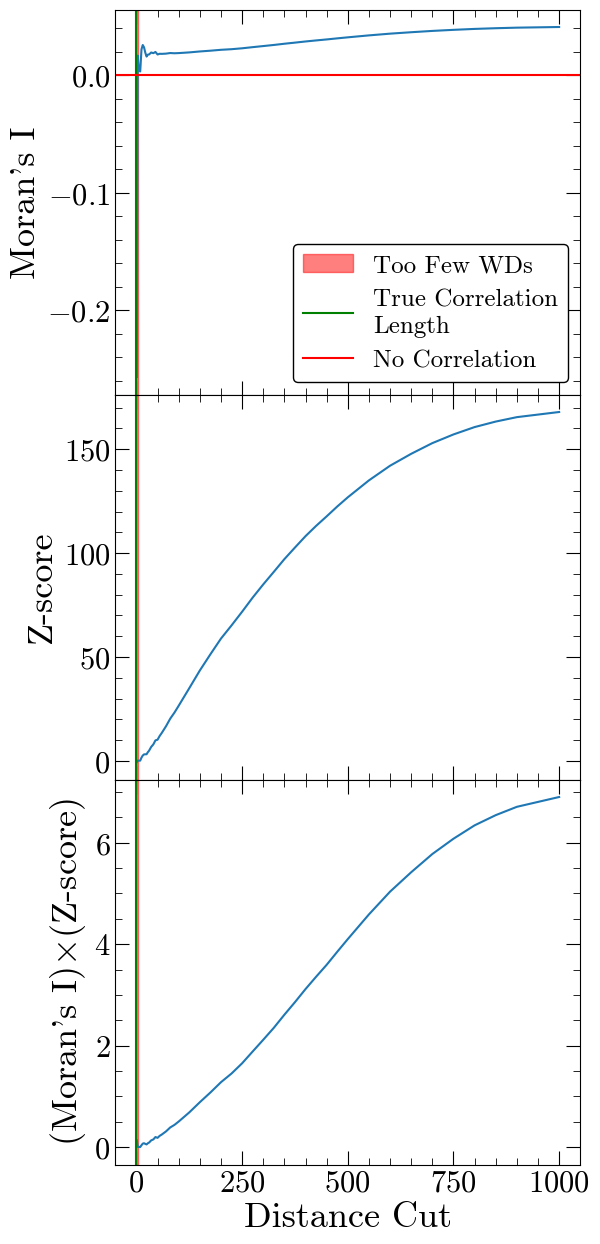

Adding thin H envelope contamination
No dark matter
Adding dust


Integrating extinction map (this might take a couple of minutes)...
Optimizing map for querying (this might take a couple of seconds)...


Adding binary contamination
Teff does not fall in binaries_effect_teff_sdss range,  -908.9800416162507
Teff does not fall in binaries_effect_teff_gaia range,  -908.9800416162507
Teff does not fall in binaries_effect_teff_sdss range,  -1162.4506168688185
Teff does not fall in binaries_effect_teff_gaia range,  -1162.4506168688185
Teff does not fall in binaries_effect_teff_sdss range,  -1583.1452508292732
Teff does not fall in binaries_effect_teff_gaia range,  -1583.1452508292732
Total Binary Contamination Proportion=  0.08374191017846637
Adding measurement noise
Adding distance uncertainty
Dropping any WD with measured radius>0.016 (low mass WDs)
Dropped  80.08433026083546  % of objects


100%|███████████████████████████████████████| 8167/8167 [12:41<00:00, 10.72it/s]


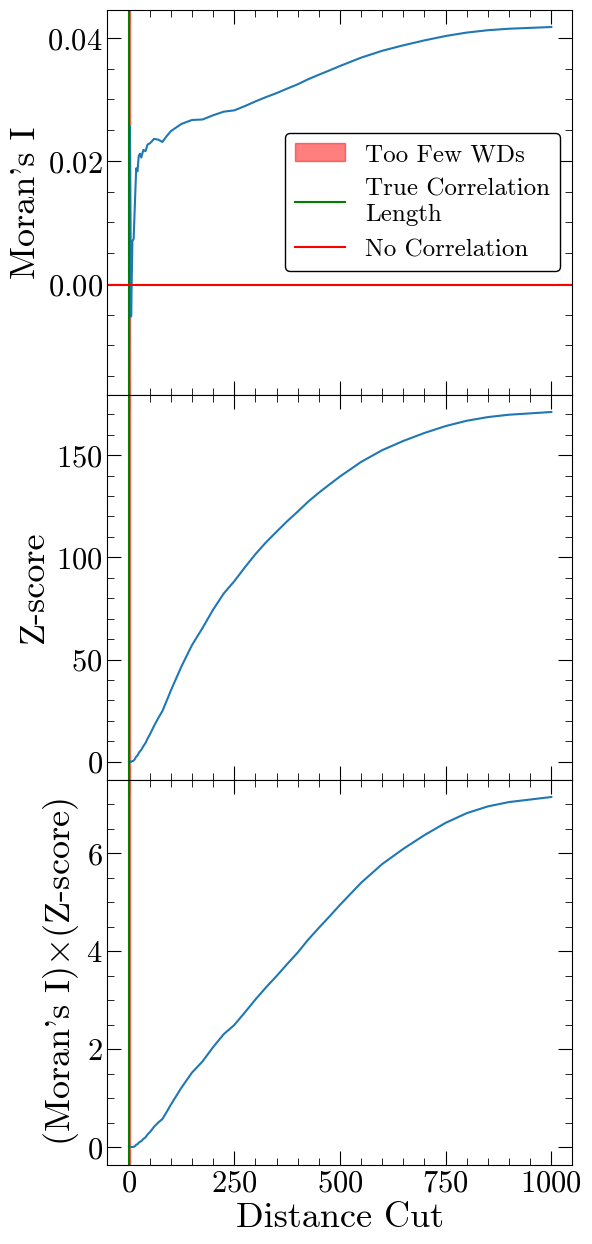

Adding thin H envelope contamination
No dark matter
Adding dust


Integrating extinction map (this might take a couple of minutes)...
Optimizing map for querying (this might take a couple of seconds)...


Adding binary contamination
Teff does not fall in binaries_effect_teff_sdss range,  -130.81953511981737
Teff does not fall in binaries_effect_teff_gaia range,  -130.81953511981737
Teff does not fall in binaries_effect_teff_sdss range,  -2783.1287070208746
Teff does not fall in binaries_effect_teff_gaia range,  -2783.1287070208746
Teff does not fall in binaries_effect_teff_sdss range,  -2850.2371814730886
Teff does not fall in binaries_effect_teff_gaia range,  -2850.2371814730886
Teff does not fall in binaries_effect_teff_sdss range,  -4184.206181474283
Teff does not fall in binaries_effect_teff_gaia range,  -4184.206181474283
Teff does not fall in binaries_effect_teff_sdss range,  -2611.178250717505
Teff does not fall in binaries_effect_teff_gaia range,  -2611.178250717505
Teff does not fall in binaries_effect_teff_sdss range,  -3277.4950068968465
Teff does not fall in binaries_effect_teff_gaia range,  -3277.4950068968465
Teff does not fall in binaries_effect_teff_sdss range,  -534.564

100%|███████████████████████████████████████| 8143/8143 [12:39<00:00, 10.72it/s]


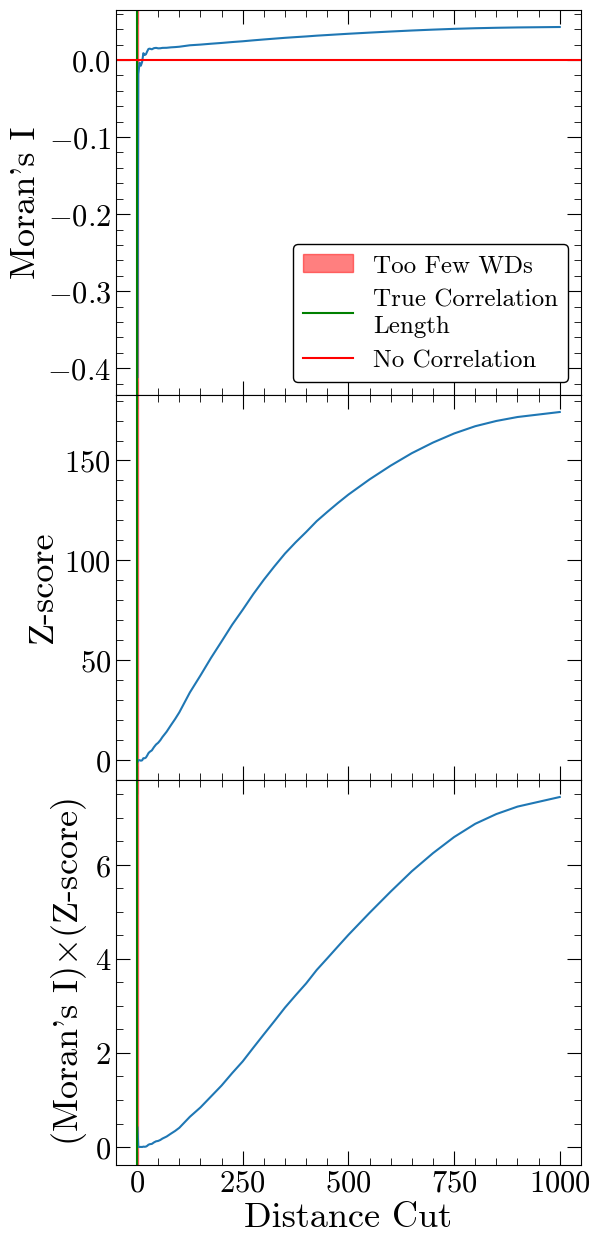

Adding thin H envelope contamination
No dark matter
Adding dust


Integrating extinction map (this might take a couple of minutes)...
Optimizing map for querying (this might take a couple of seconds)...


Adding binary contamination
Teff does not fall in binaries_effect_teff_sdss range,  -2621.1905649468526
Teff does not fall in binaries_effect_teff_gaia range,  -2621.1905649468526
Teff does not fall in binaries_effect_teff_sdss range,  -3279.4956483137776
Teff does not fall in binaries_effect_teff_gaia range,  -3279.4956483137776
Teff does not fall in binaries_effect_teff_sdss range,  -518.3029275065146
Teff does not fall in binaries_effect_teff_gaia range,  -518.3029275065146
Teff does not fall in binaries_effect_teff_sdss range,  -2748.549663318887
Teff does not fall in binaries_effect_teff_gaia range,  -2748.549663318887
Teff does not fall in binaries_effect_teff_sdss range,  -1937.0878079406102
Teff does not fall in binaries_effect_teff_gaia range,  -1937.0878079406102
Teff does not fall in binaries_effect_teff_sdss range,  -2550.4031891639524
Teff does not fall in binaries_effect_teff_gaia range,  -2550.4031891639524
Teff does not fall in binaries_effect_teff_sdss range,  -2840.40

100%|███████████████████████████████████████| 8124/8124 [12:35<00:00, 10.75it/s]


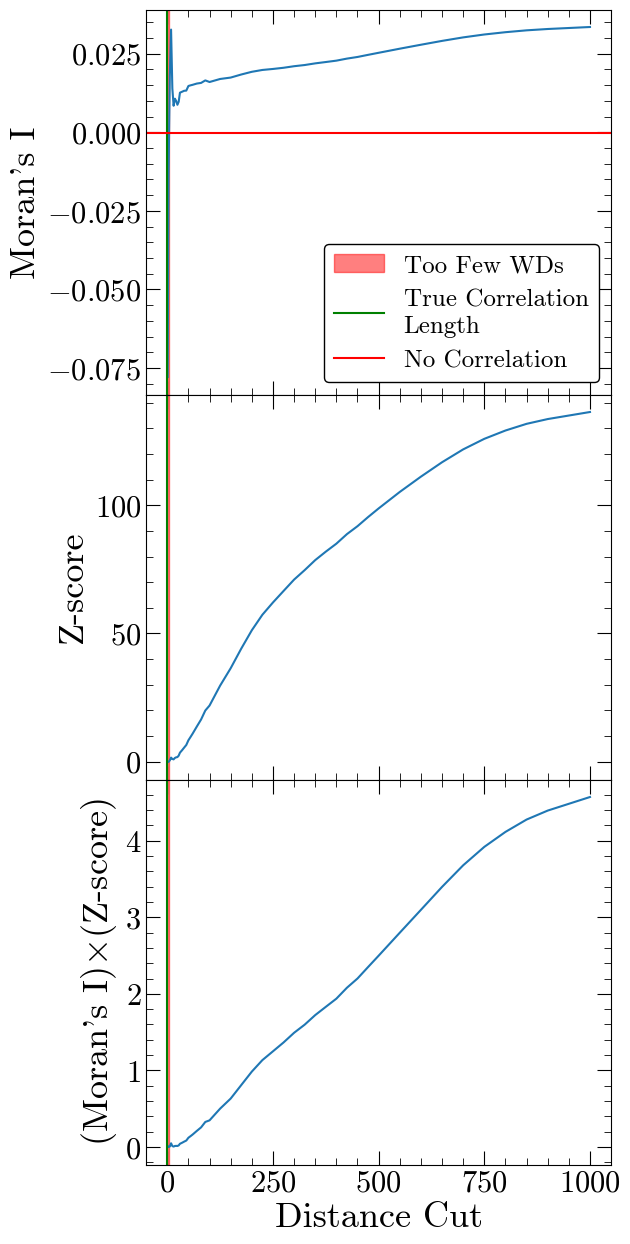

In [61]:
#with all effects
print('all effects, no ULDM')
noise_effect_array=['1','1','1','1','1']
chance_companion=0.01
improvement_factor=1
effect_strength=1
remove_likely_binaries='1' #remove low mass objects

for i in range(10):
    full_simulation(corr_length,epsilon,sample_size,grid_size,distances,chance_companion,improvement_factor,effect_strength,
                noise_effect_array,remove_likely_binaries,iternum=i)
    output=get_output(corr_length,epsilon,sample_size,chance_companion,improvement_factor,effect_strength,noise_effect_array,
                  remove_likely_binaries,no_dark_matter=True,iternum=i)

all effects, no ULDM
Adding thin H envelope contamination
No dark matter
Adding dust


Integrating extinction map (this might take a couple of minutes)...
Optimizing map for querying (this might take a couple of seconds)...


Adding binary contamination
Total Binary Contamination Proportion=  0.09280674245393963
Adding measurement noise
Adding distance uncertainty
Dropping any WD with measured radius>0.016 (low mass WDs)
Dropped  86.16228929831439  % of objects


100%|███████████████████████████████████████| 8792/8792 [14:49<00:00,  9.88it/s]


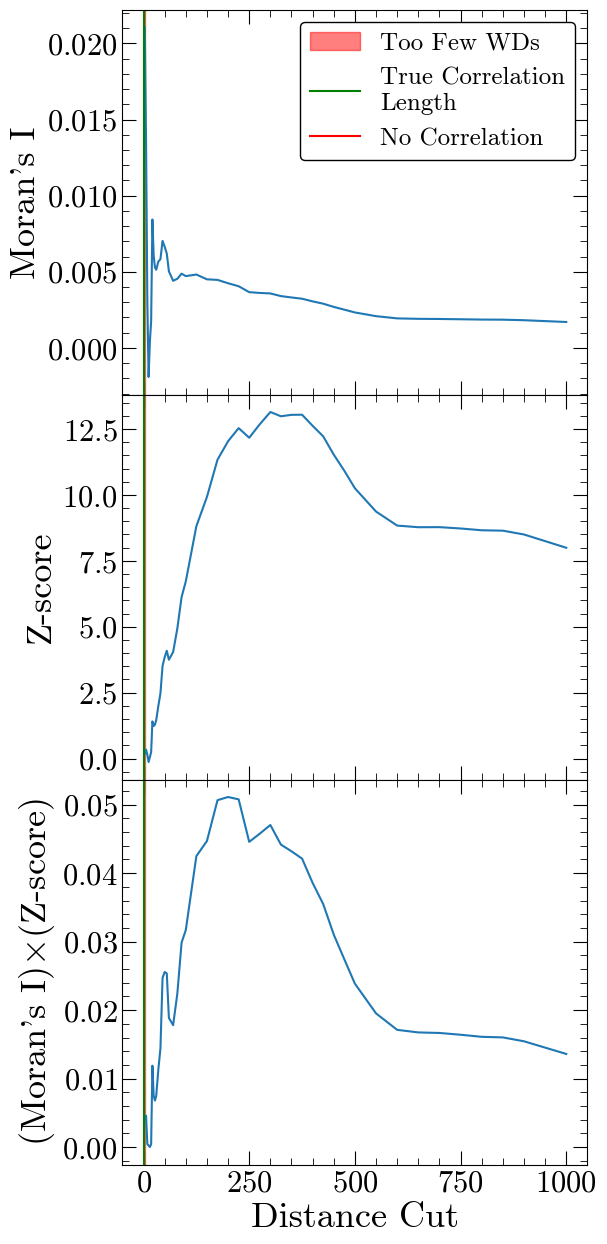

Adding thin H envelope contamination
No dark matter
Adding dust


Integrating extinction map (this might take a couple of minutes)...
Optimizing map for querying (this might take a couple of seconds)...


Adding binary contamination
Total Binary Contamination Proportion=  0.08197685820749166
Adding measurement noise
Adding distance uncertainty
Dropping any WD with measured radius>0.016 (low mass WDs)
Dropped  87.40929594038047  % of objects


100%|███████████████████████████████████████| 8914/8914 [15:13<00:00,  9.75it/s]


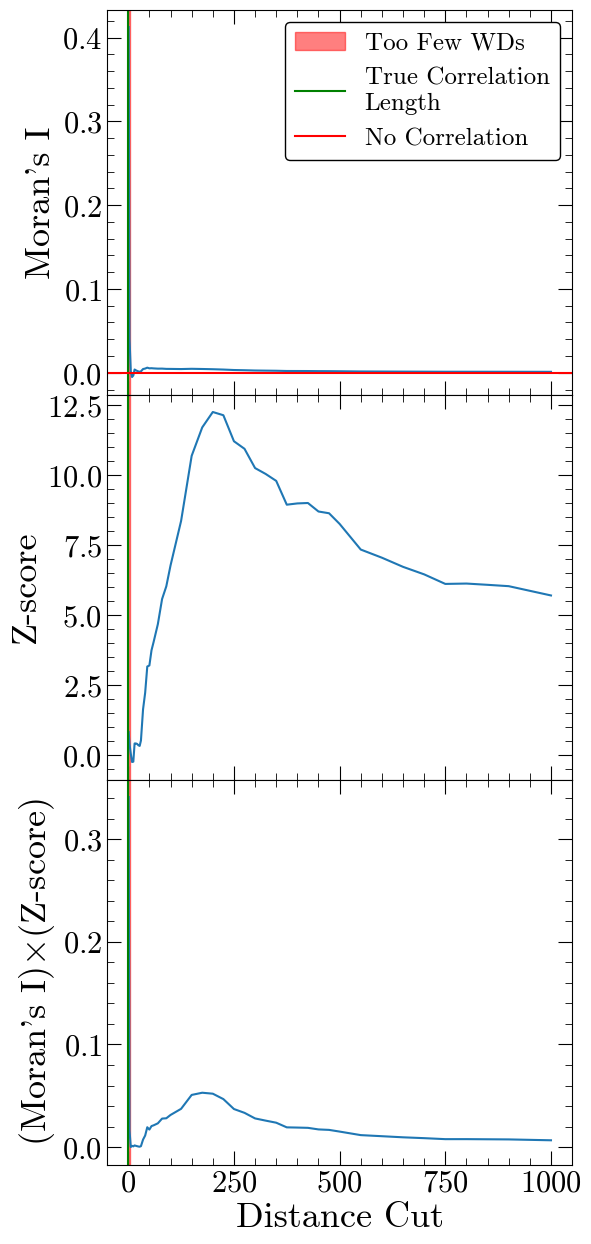

Adding thin H envelope contamination
No dark matter
Adding dust


Integrating extinction map (this might take a couple of minutes)...
Optimizing map for querying (this might take a couple of seconds)...


Adding binary contamination
Total Binary Contamination Proportion=  0.08371728261935105
Adding measurement noise
Adding distance uncertainty
Dropping any WD with measured radius>0.016 (low mass WDs)
Dropped  87.52083129104989  % of objects


100%|███████████████████████████████████████| 8928/8928 [15:22<00:00,  9.68it/s]


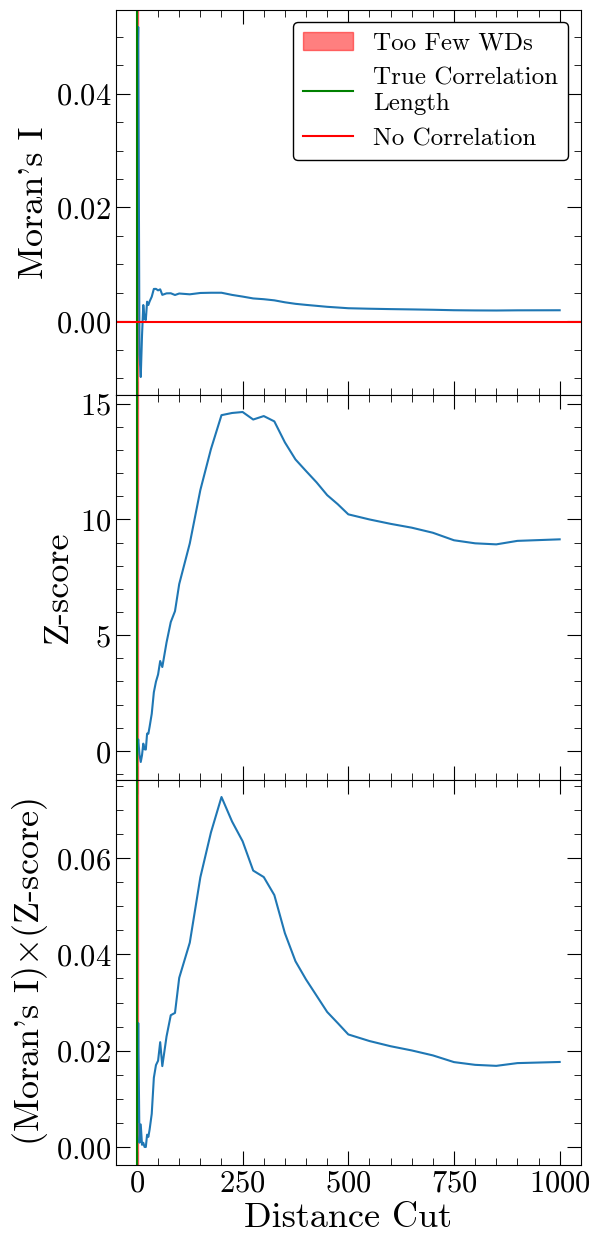

Adding thin H envelope contamination
No dark matter
Adding dust


Integrating extinction map (this might take a couple of minutes)...
Optimizing map for querying (this might take a couple of seconds)...


Adding binary contamination
Total Binary Contamination Proportion=  0.08732725668920906
Adding measurement noise
Adding distance uncertainty
Dropping any WD with measured radius>0.016 (low mass WDs)
Dropped  86.7489953935117  % of objects


100%|███████████████████████████████████████| 8851/8851 [15:04<00:00,  9.79it/s]


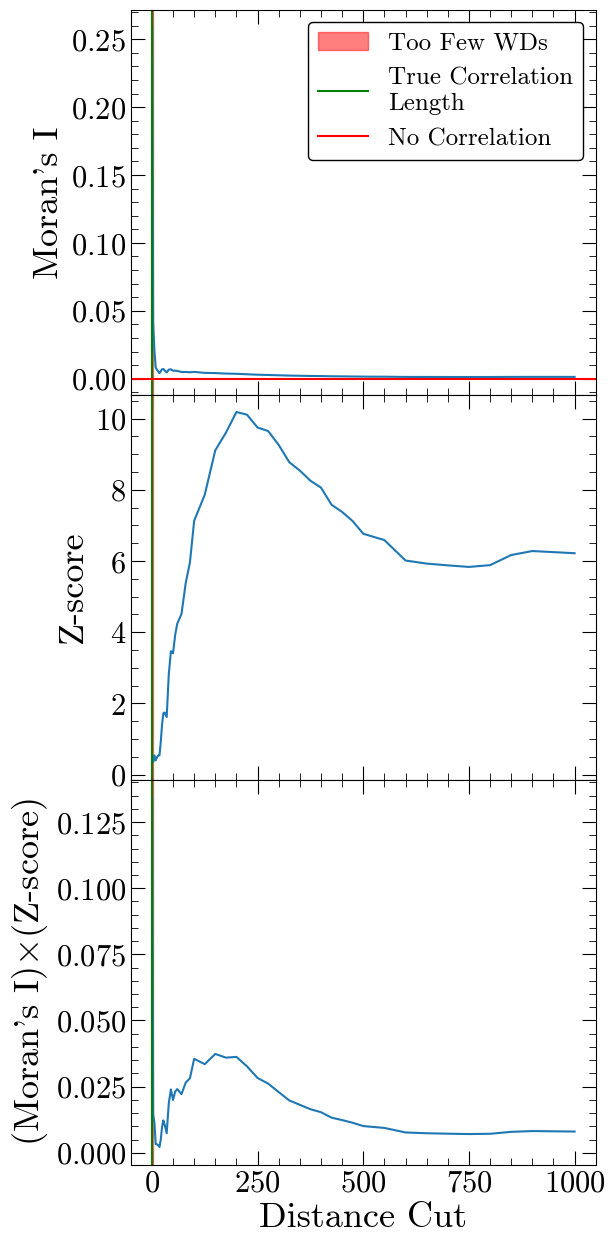

Adding thin H envelope contamination
No dark matter
Adding dust


Integrating extinction map (this might take a couple of minutes)...
Optimizing map for querying (this might take a couple of seconds)...


Adding binary contamination
Total Binary Contamination Proportion=  0.08762987649480494
Adding measurement noise
Adding distance uncertainty
Dropping any WD with measured radius>0.016 (low mass WDs)
Dropped  86.86532052538718  % of objects


100%|███████████████████████████████████████| 8862/8862 [15:09<00:00,  9.74it/s]


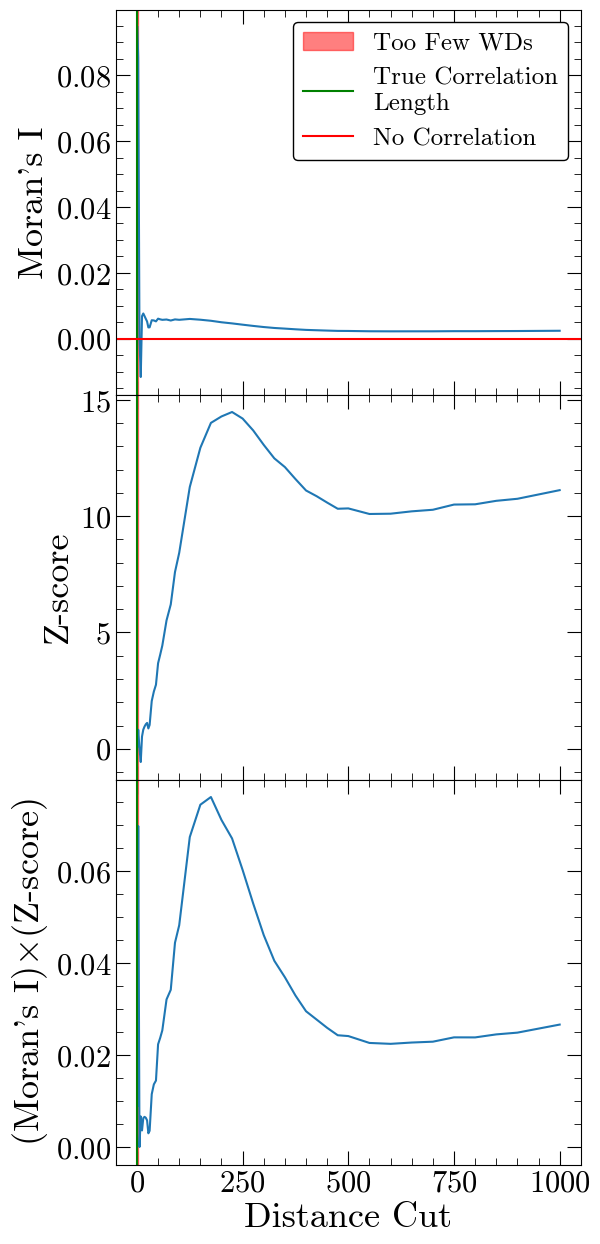

Adding thin H envelope contamination
No dark matter
Adding dust


Integrating extinction map (this might take a couple of minutes)...
Optimizing map for querying (this might take a couple of seconds)...


Adding binary contamination
Total Binary Contamination Proportion=  0.08824394548485145
Adding measurement noise
Adding distance uncertainty
Dropping any WD with measured radius>0.016 (low mass WDs)
Dropped  86.43984704382783  % of objects


100%|███████████████████████████████████████| 8816/8816 [14:57<00:00,  9.82it/s]


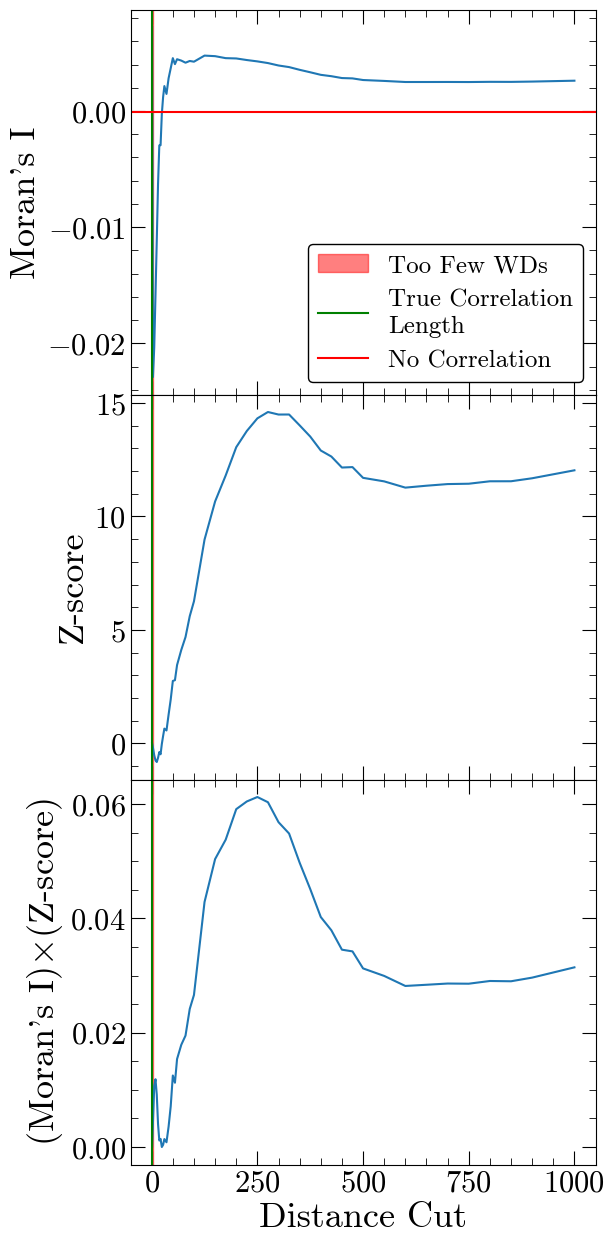

Adding thin H envelope contamination
No dark matter
Adding dust


Integrating extinction map (this might take a couple of minutes)...
Optimizing map for querying (this might take a couple of seconds)...


Adding binary contamination
Total Binary Contamination Proportion=  0.08484551250613045
Adding measurement noise
Adding distance uncertainty
Dropping any WD with measured radius>0.016 (low mass WDs)
Dropped  87.16037273173124  % of objects


100%|███████████████████████████████████████| 8886/8886 [15:09<00:00,  9.76it/s]


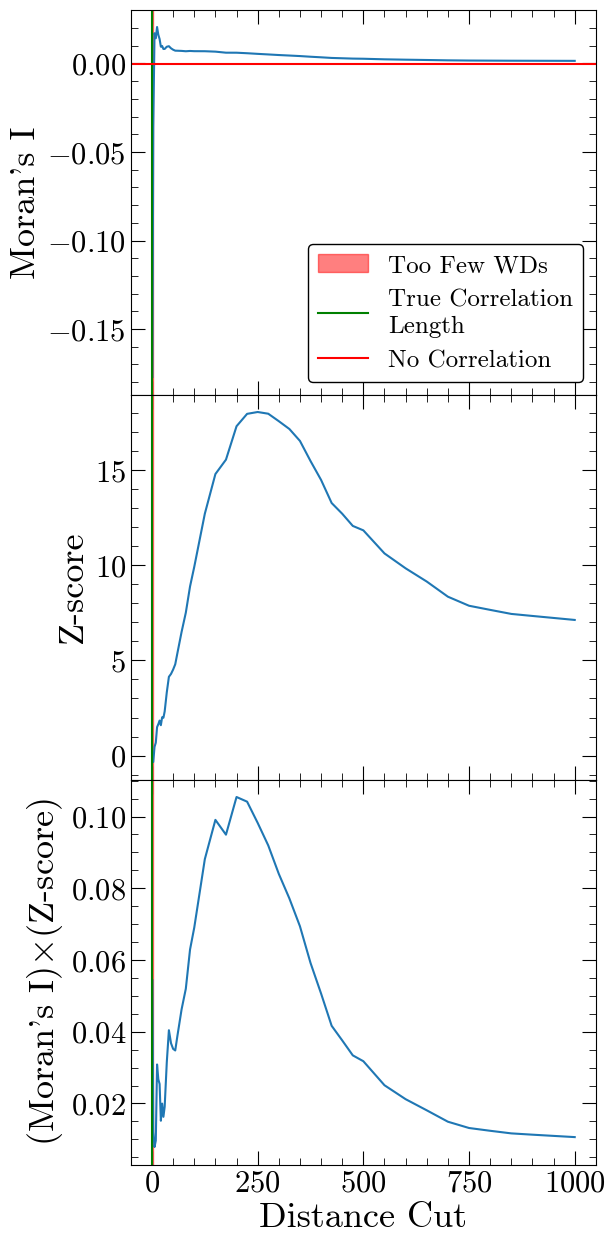

Adding thin H envelope contamination
No dark matter
Adding dust


Integrating extinction map (this might take a couple of minutes)...
Optimizing map for querying (this might take a couple of seconds)...


Adding binary contamination
Total Binary Contamination Proportion=  0.09330589042438499
Adding measurement noise
Adding distance uncertainty
Dropping any WD with measured radius>0.016 (low mass WDs)
Dropped  86.43536214838772  % of objects


100%|███████████████████████████████████████| 8819/8819 [14:52<00:00,  9.88it/s]


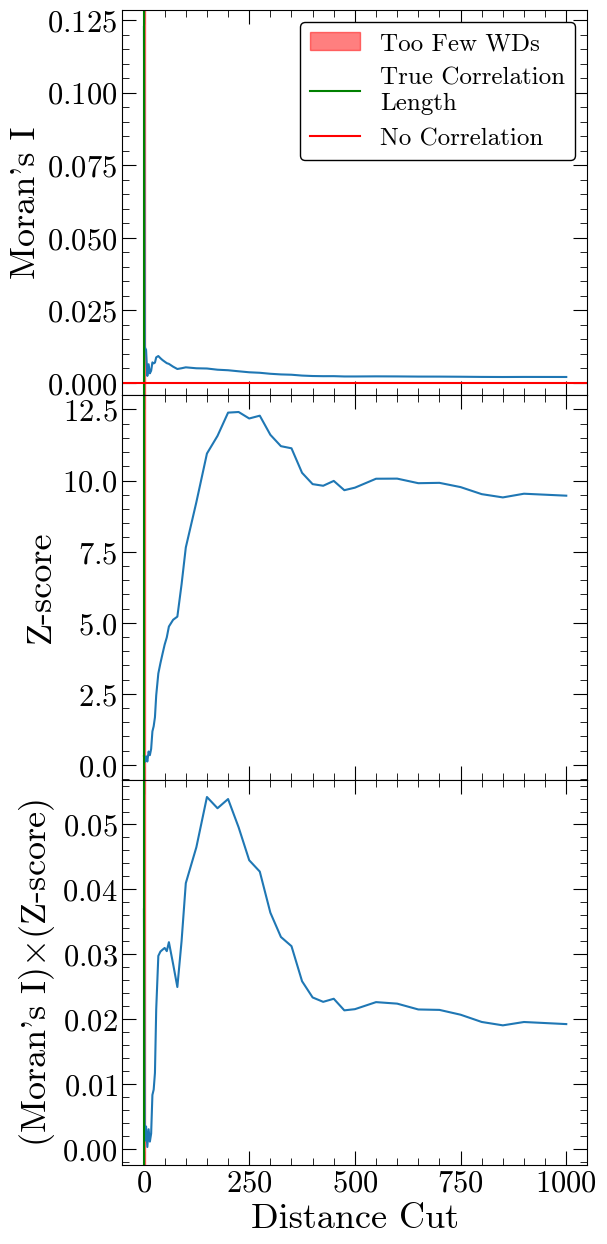

Adding thin H envelope contamination
No dark matter
Adding dust


Integrating extinction map (this might take a couple of minutes)...
Optimizing map for querying (this might take a couple of seconds)...


Adding binary contamination
Total Binary Contamination Proportion=  0.08558823529411765
Adding measurement noise
Adding distance uncertainty
Dropping any WD with measured radius>0.016 (low mass WDs)
Dropped  86.75490196078431  % of objects


100%|███████████████████████████████████████| 8849/8849 [15:03<00:00,  9.79it/s]


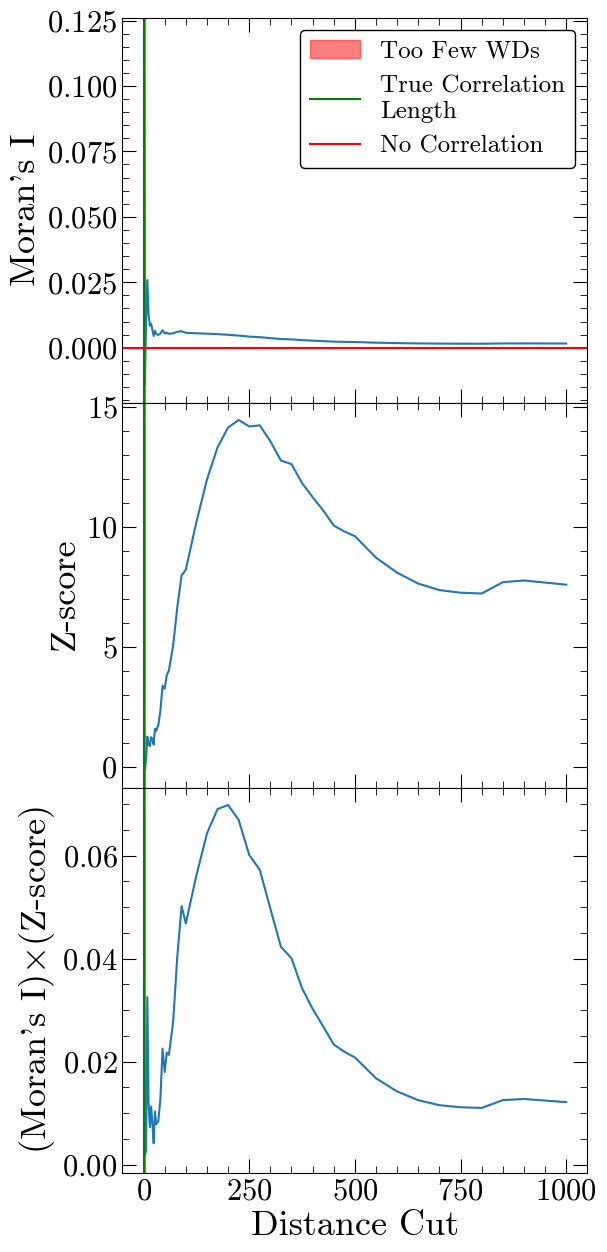

Adding thin H envelope contamination
No dark matter
Adding dust


Integrating extinction map (this might take a couple of minutes)...
Optimizing map for querying (this might take a couple of seconds)...


Adding binary contamination
Total Binary Contamination Proportion=  0.08656014116263111
Adding measurement noise
Adding distance uncertainty
Dropping any WD with measured radius>0.016 (low mass WDs)
Dropped  86.98166846387609  % of objects


100%|███████████████████████████████████████| 8873/8873 [15:12<00:00,  9.73it/s]


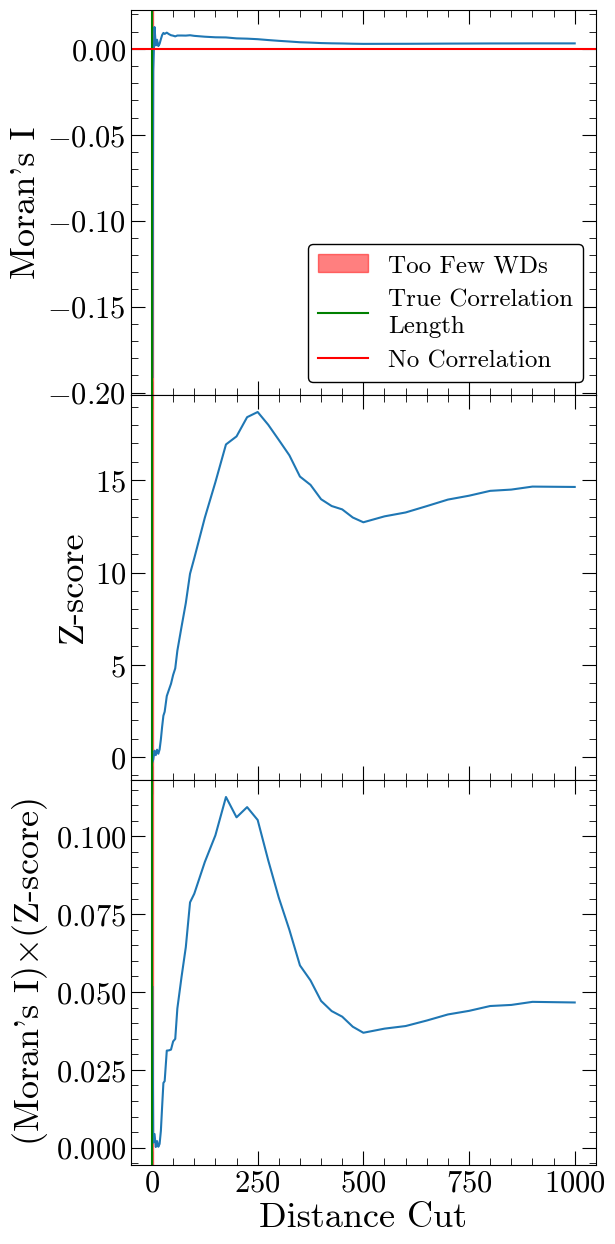

In [62]:
#with all effects,reduce measurement noise and dust effect strength by order of magnitude
print('all effects, no ULDM')
noise_effect_array=['1','1','1','1','1']
chance_companion=0.01
improvement_factor=10
effect_strength=10
remove_likely_binaries='1' #remove low mass objects

for i in range(10):
    full_simulation(corr_length,epsilon,sample_size,grid_size,distances,chance_companion,improvement_factor,effect_strength,
                noise_effect_array,remove_likely_binaries,iternum=i)
    output=get_output(corr_length,epsilon,sample_size,chance_companion,improvement_factor,effect_strength,noise_effect_array,
                  remove_likely_binaries,no_dark_matter=True,iternum=i)

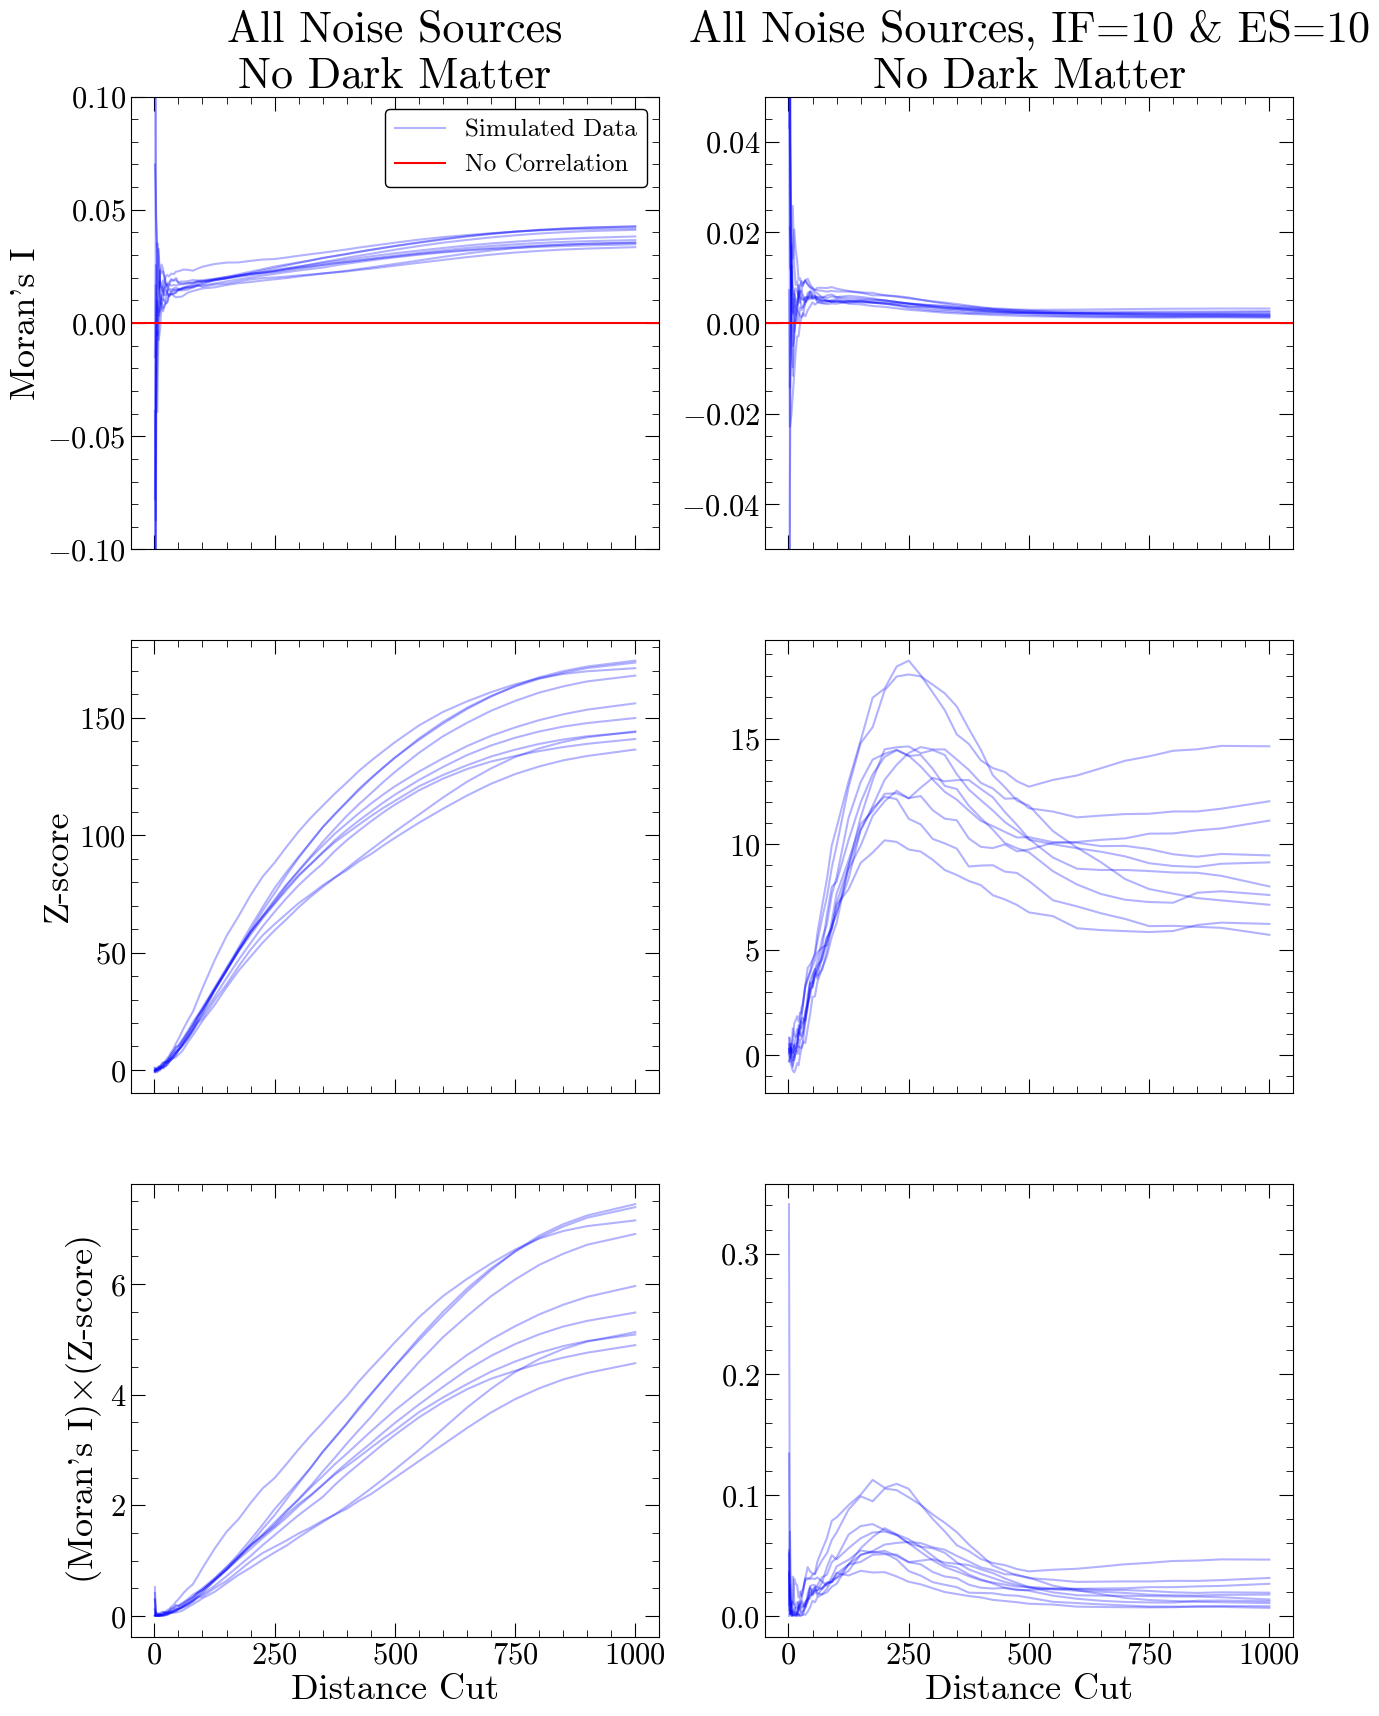

In [71]:
sample_size=10207
grid_size=1000
corr_length=0
epsilon=0 

fig, ((ax1,ax4),(ax2,ax5),(ax3,ax6)) = plt.subplots(3,2,figsize=(15,20),sharex=True)

#all noise sources turned on, remove likely binaries, and no dark matter
noise_effect_array=['1','1','1','1','1']
chance_companion=0.01
improvement_factor=1
effect_strength=1
remove_likely_binaries='1'
for i in range(10):
    final_distances,med_abs_deviations,Ws,moransIs,expectations,variances,zscores,mult,index=get_output(corr_length,epsilon,sample_size,chance_companion,improvement_factor,effect_strength,noise_effect_array,
                      remove_likely_binaries,no_dark_matter=True,iternum=i,nonzero_weight_cut=100,plot=False)
    if i==0:
        ax1.plot(final_distances,moransIs,color='blue',alpha=0.3,label='Simulated Data')
    else:
        ax1.plot(final_distances,moransIs,color='blue',alpha=0.3)
    ax2.plot(final_distances,zscores,color='blue',alpha=0.3)
    ax3.plot(final_distances,mult,color='blue',alpha=0.3)    
ax1.axhline(expectations[0],color='red',label='No Correlation')
ax1.set_ylabel("Moran's I")
ax1.legend()
ax2.set_ylabel('Z-score')
ax3.set_xlabel('Distance Cut')
ax3.set_ylabel(r"(Moran's I)$\times$(Z-score)")
ax1.set_title('All Noise Sources\nNo Dark Matter')
    
#all noise sources turned on, remove likely binaries, reduce measurement noise and
#dust effect by order of magnitude (improvement_factor=10, effect_strength=10), no dark matter
noise_effect_array=['1','1','1','1','1']
chance_companion=0.01
improvement_factor=10
effect_strength=10
remove_likely_binaries='1'
for i in range(10):
    final_distances,med_abs_deviations,Ws,moransIs,expectations,variances,zscores,mult,index=get_output(corr_length,epsilon,sample_size,chance_companion,improvement_factor,effect_strength,noise_effect_array,
                      remove_likely_binaries,no_dark_matter=True,iternum=i,nonzero_weight_cut=100,plot=False)
    if i==0:
        ax4.plot(final_distances,moransIs,color='blue',alpha=0.3,label='Simulated Data')
    else:
        ax4.plot(final_distances,moransIs,color='blue',alpha=0.3)
    ax5.plot(final_distances,zscores,color='blue',alpha=0.3)
    ax6.plot(final_distances,mult,color='blue',alpha=0.3)
ax4.axhline(expectations[0],color='red',label='No Correlation')
ax6.set_xlabel('Distance Cut')
ax4.set_title('All Noise Sources, IF=10 & ES=10\nNo Dark Matter')

ax1.set_ylim(-0.1,0.1)
ax4.set_ylim(-0.05,0.05)

fig.savefig('noULDM.pdf')
